A continuación se muestarn las comparaciones a partir de los 10 mejores modelos de la primer etapa (con dropout y sin batch normalization). Se entrenaron 10 modelos replicando los hiperparámetros del grupo control y agregando BatchNorm (con dropout y batch normalization). Debido a que puede haber interferencias entre ellos, se decidió también entrenar 10 modelos con esos hiperparámetros pero sin dropout (sin dropout y con batch normalization). A partir de ello, se puede ver como afectan dropout y batchnorm al entrenamiento, tanto en conjunto como por separado.

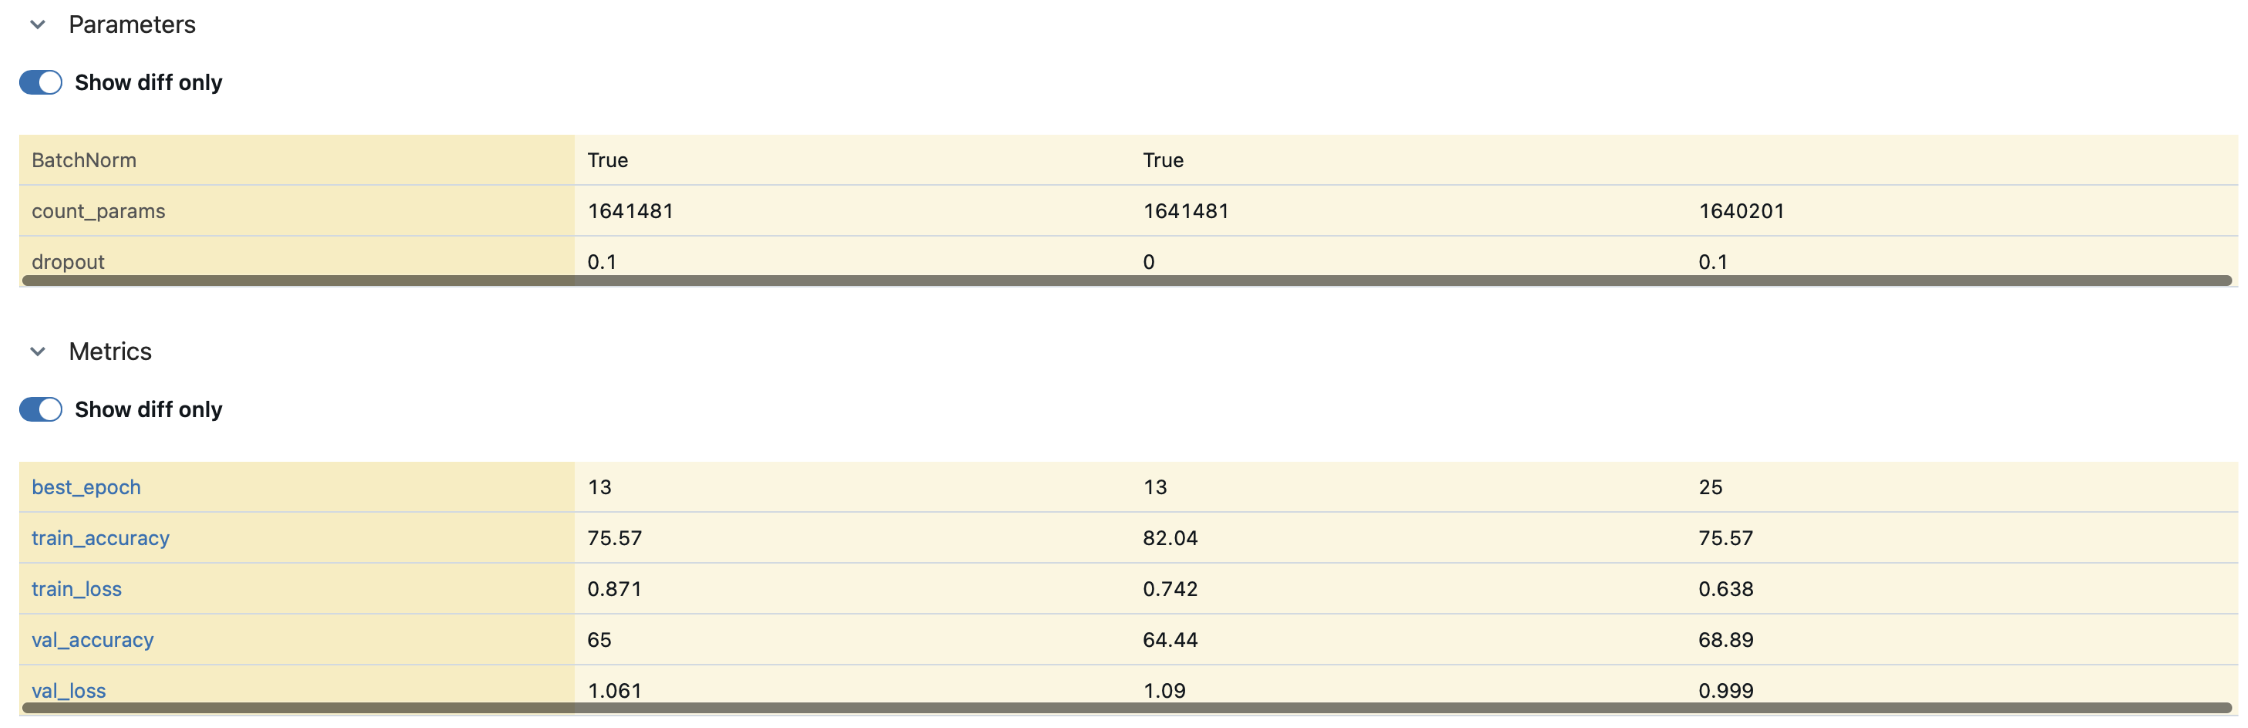

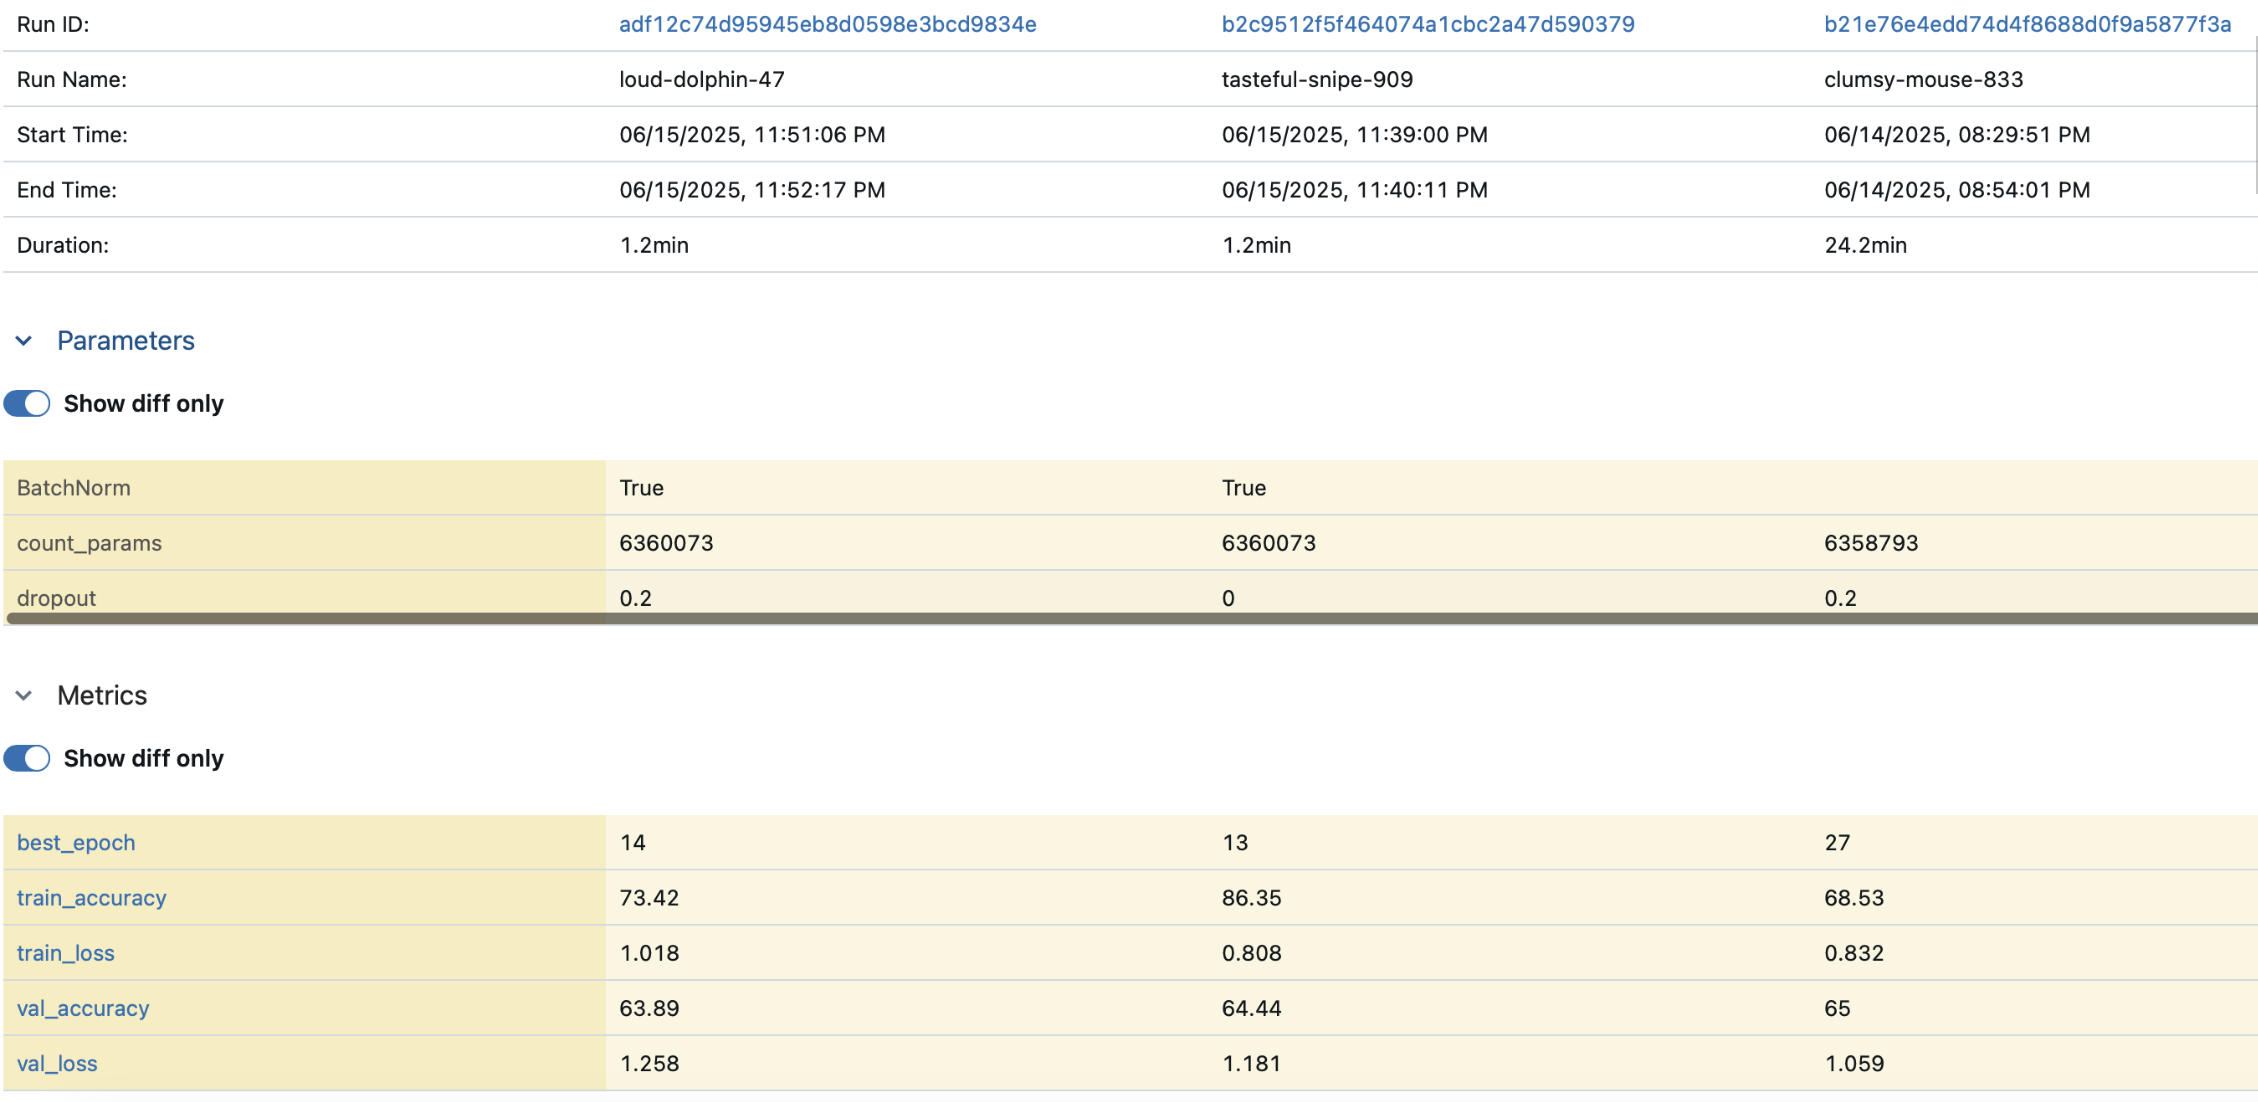

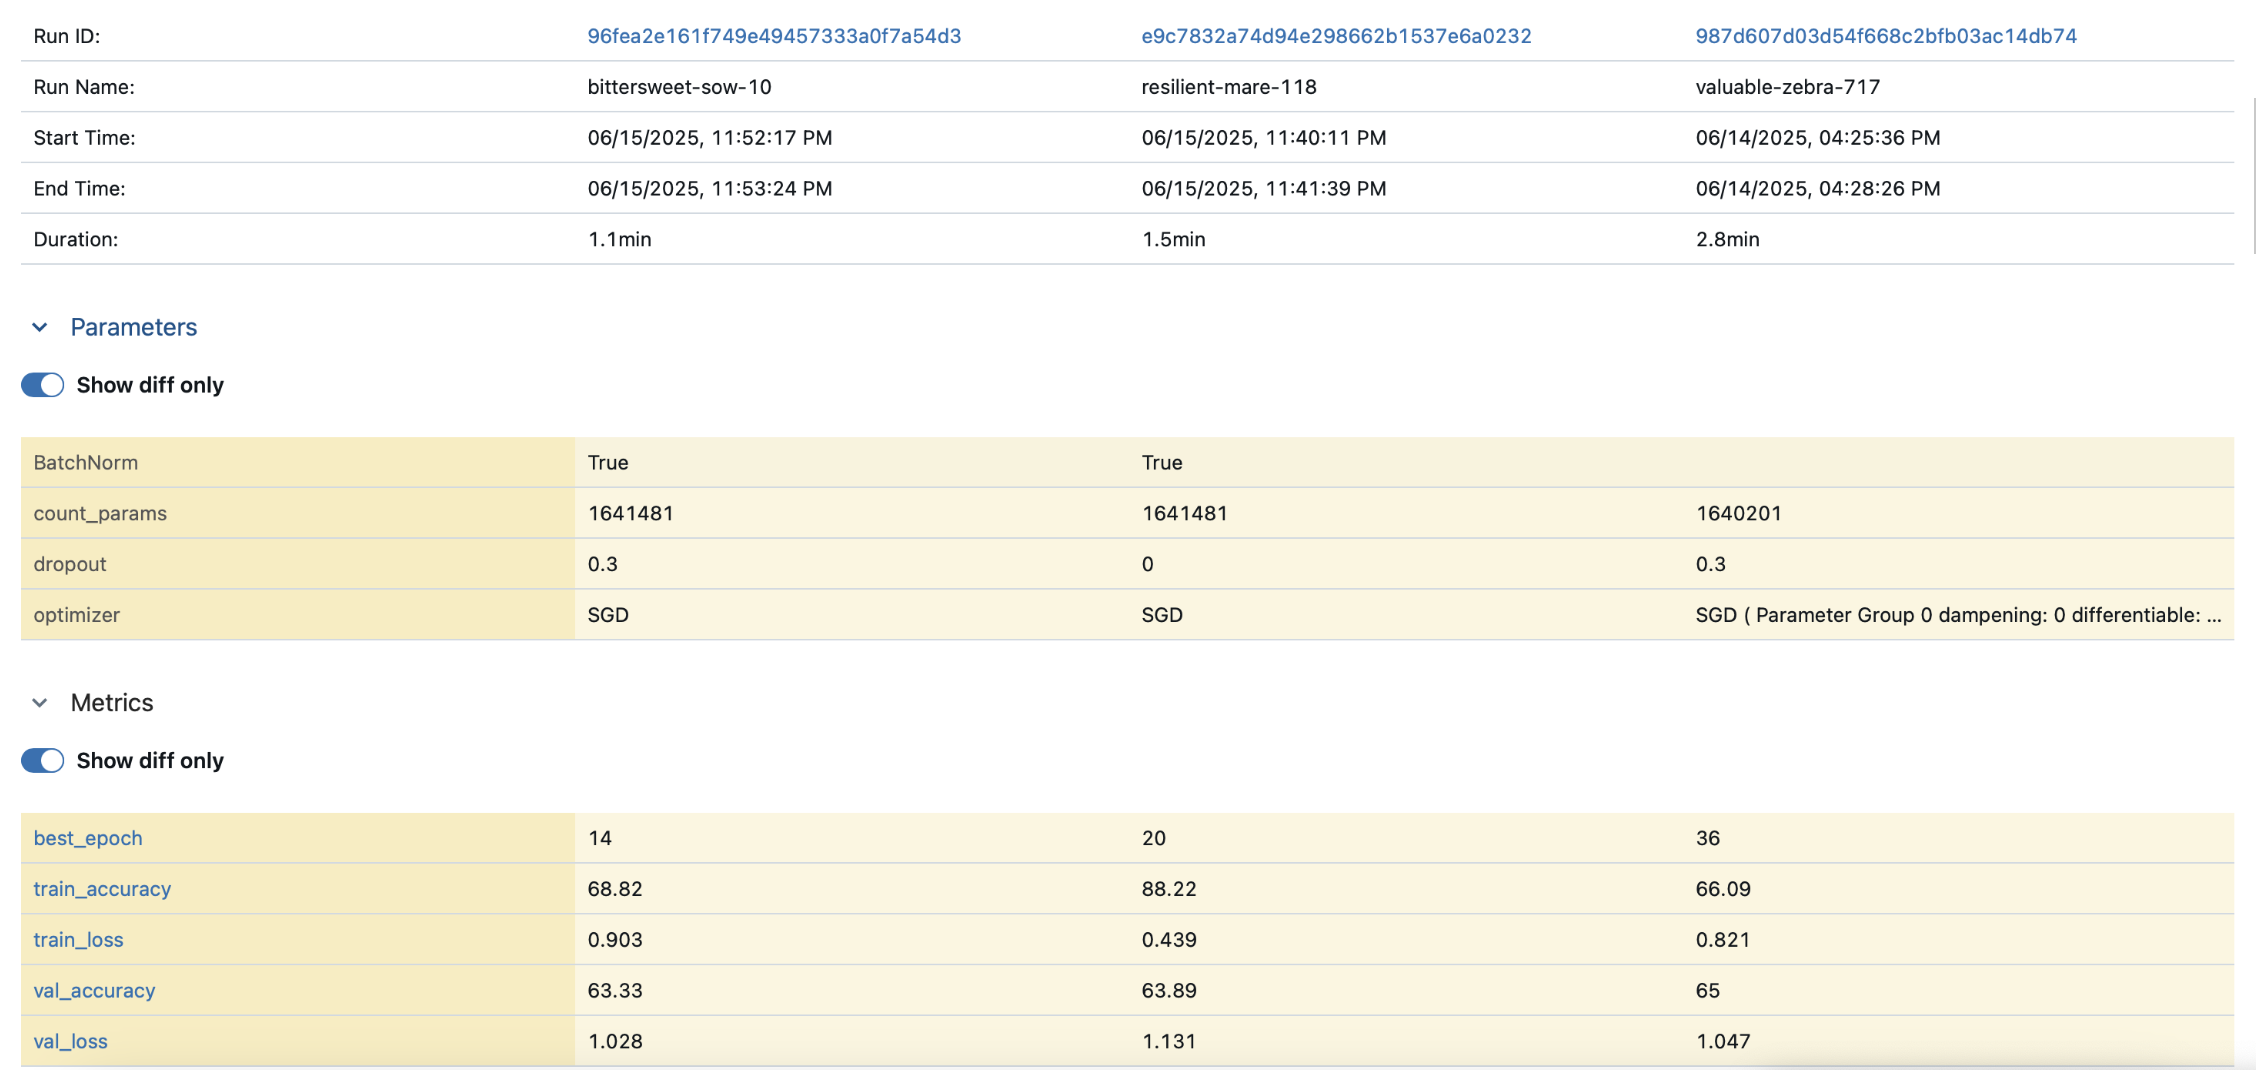

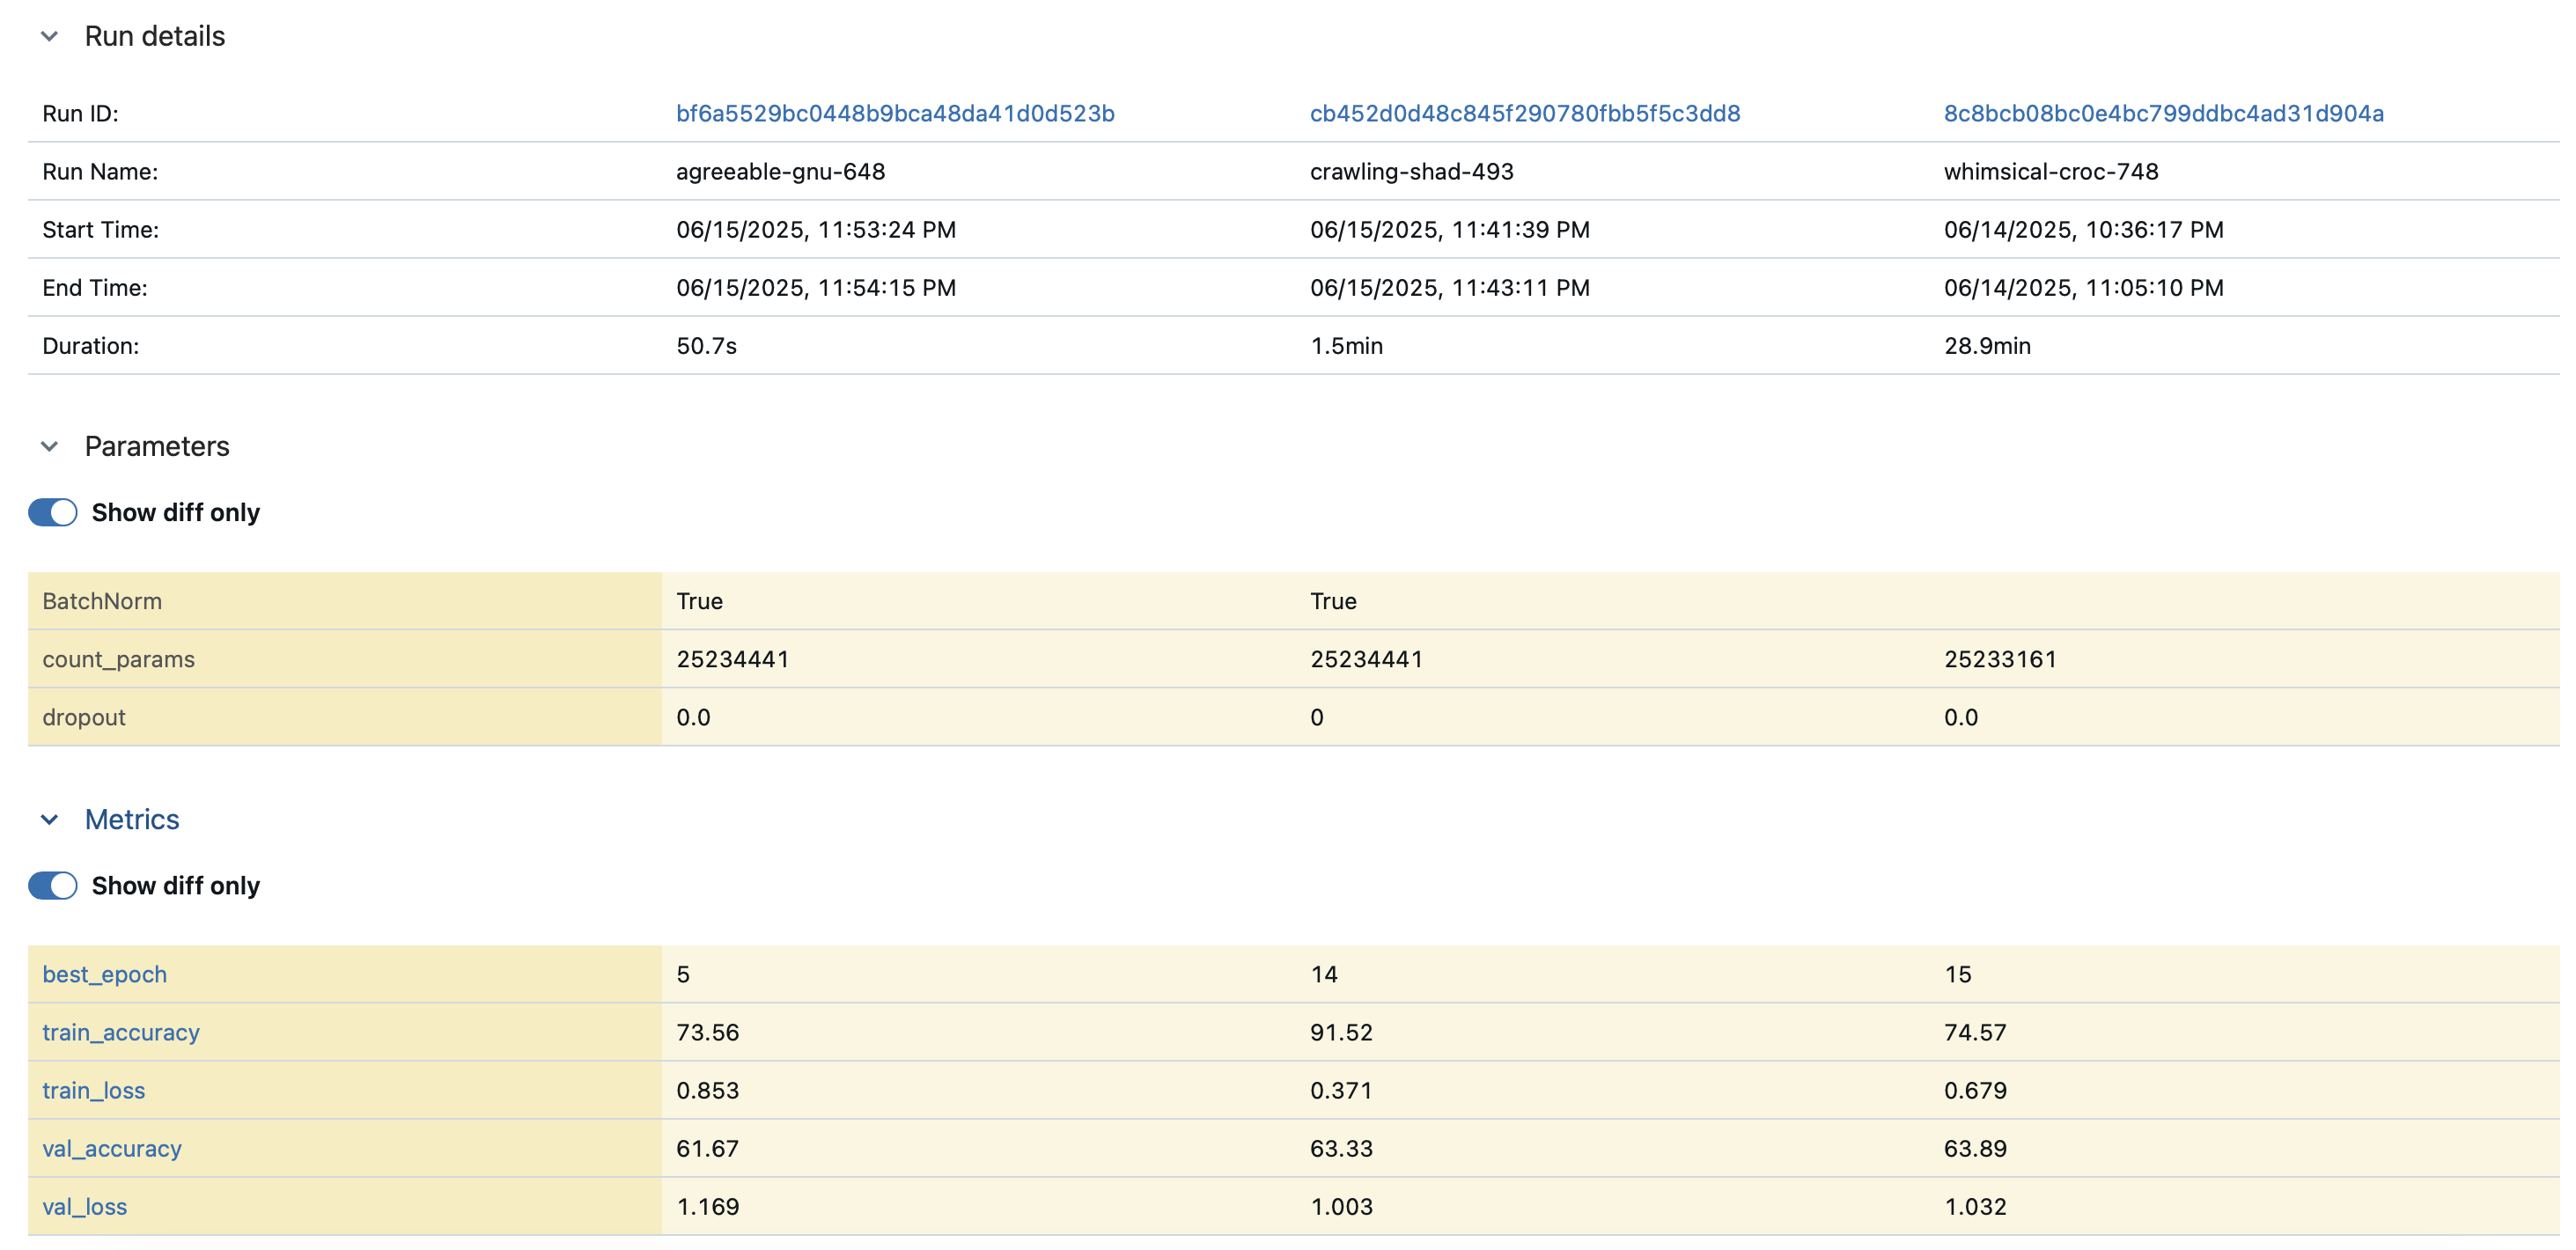

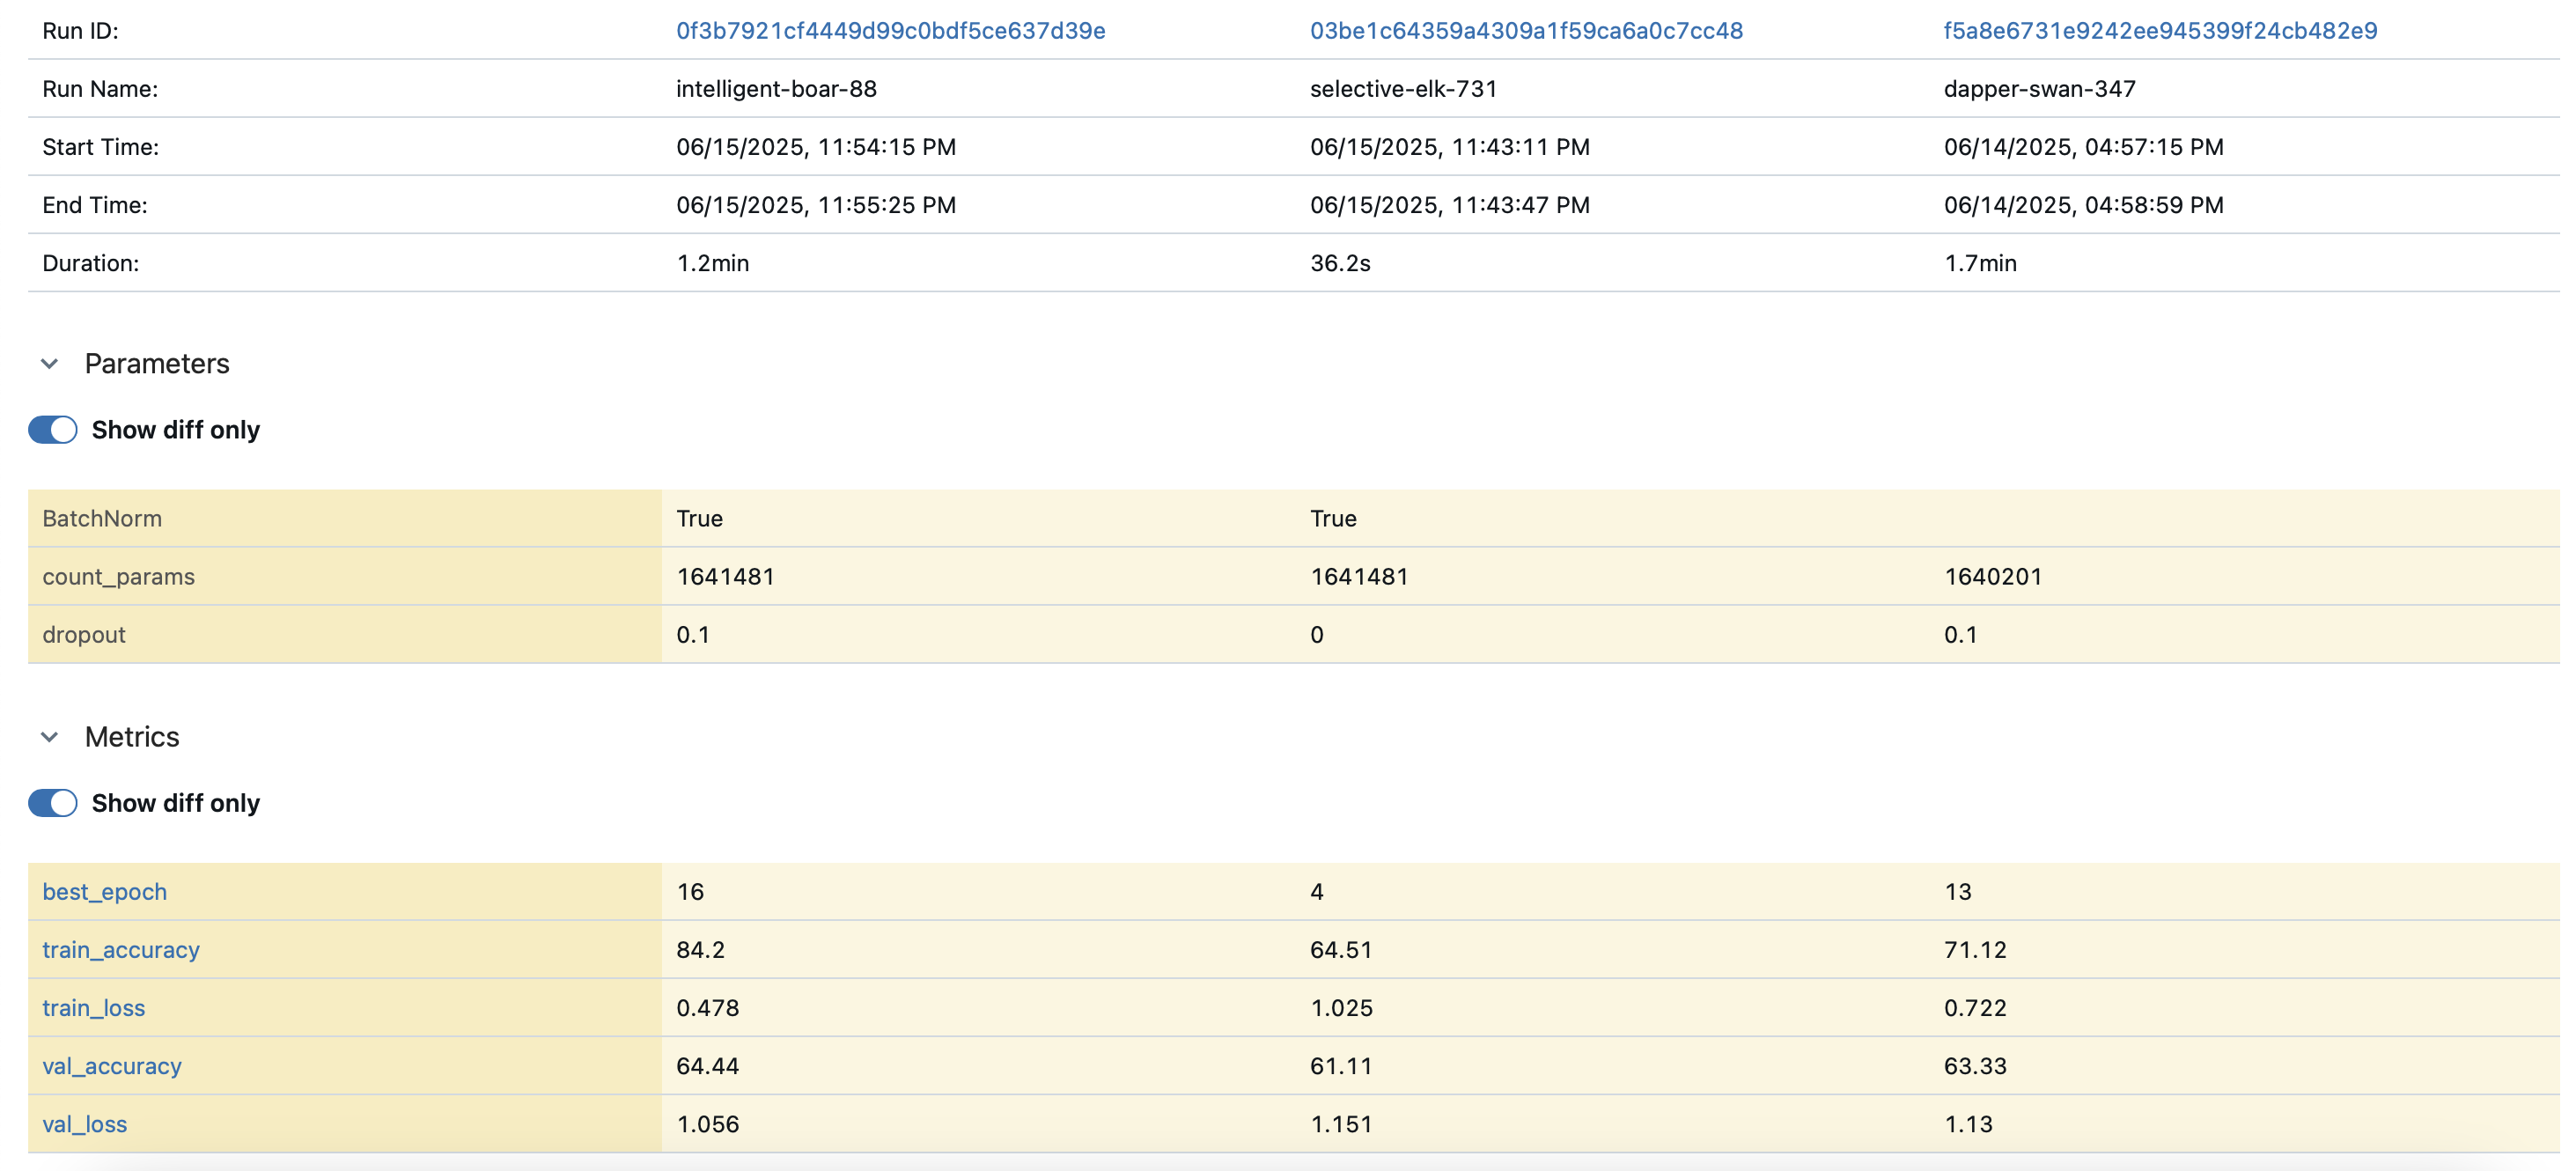

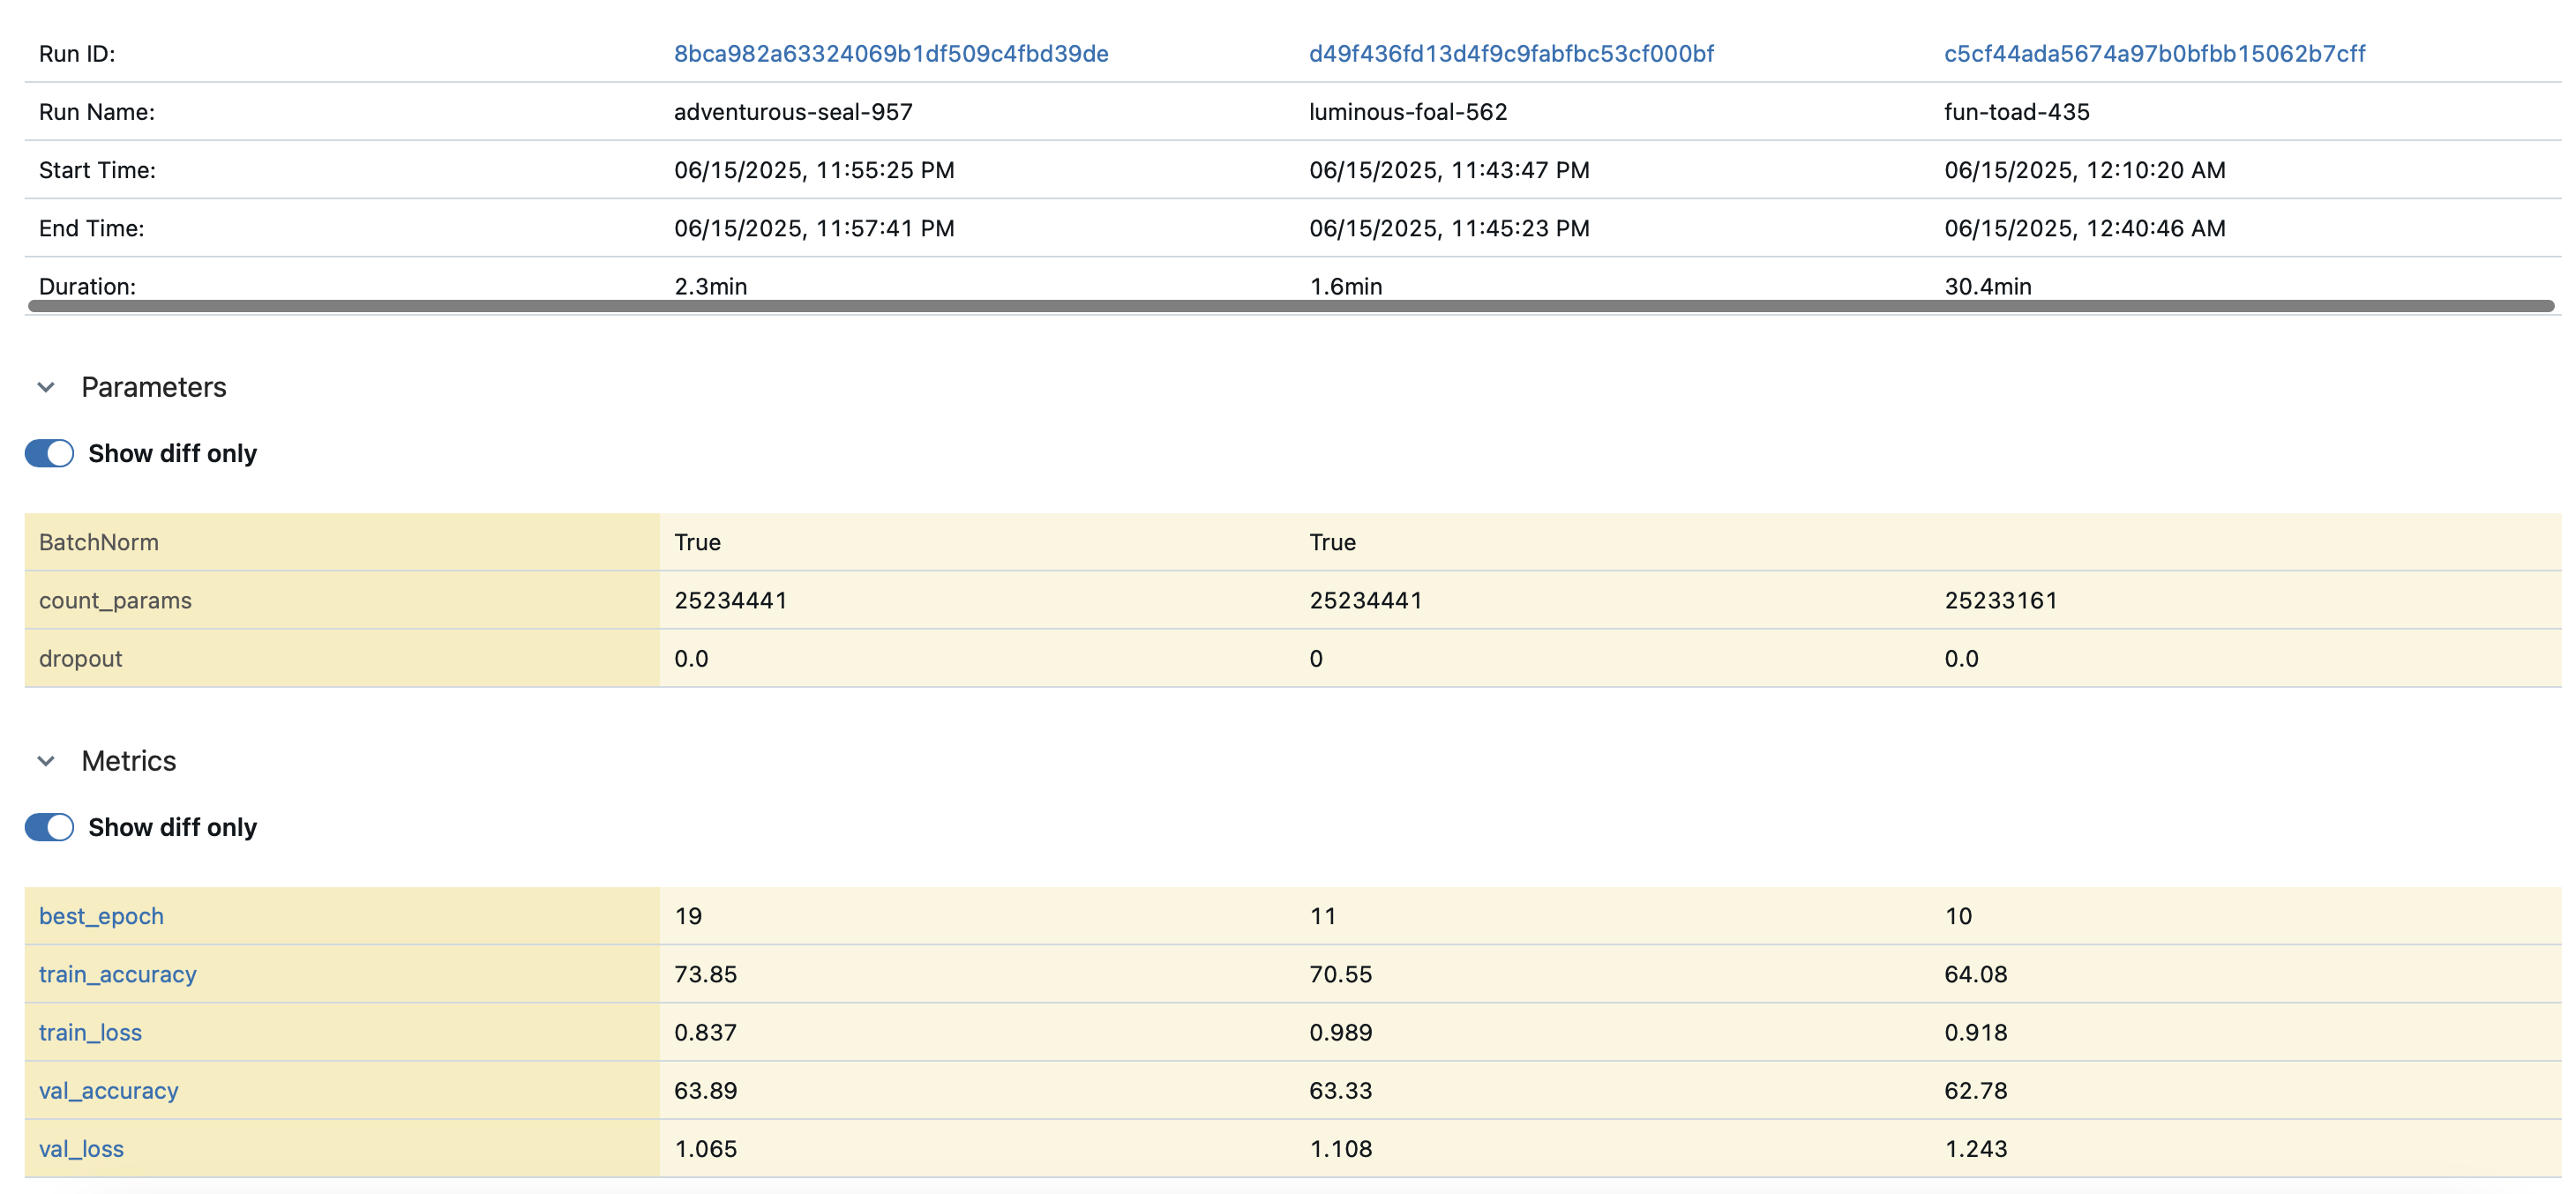

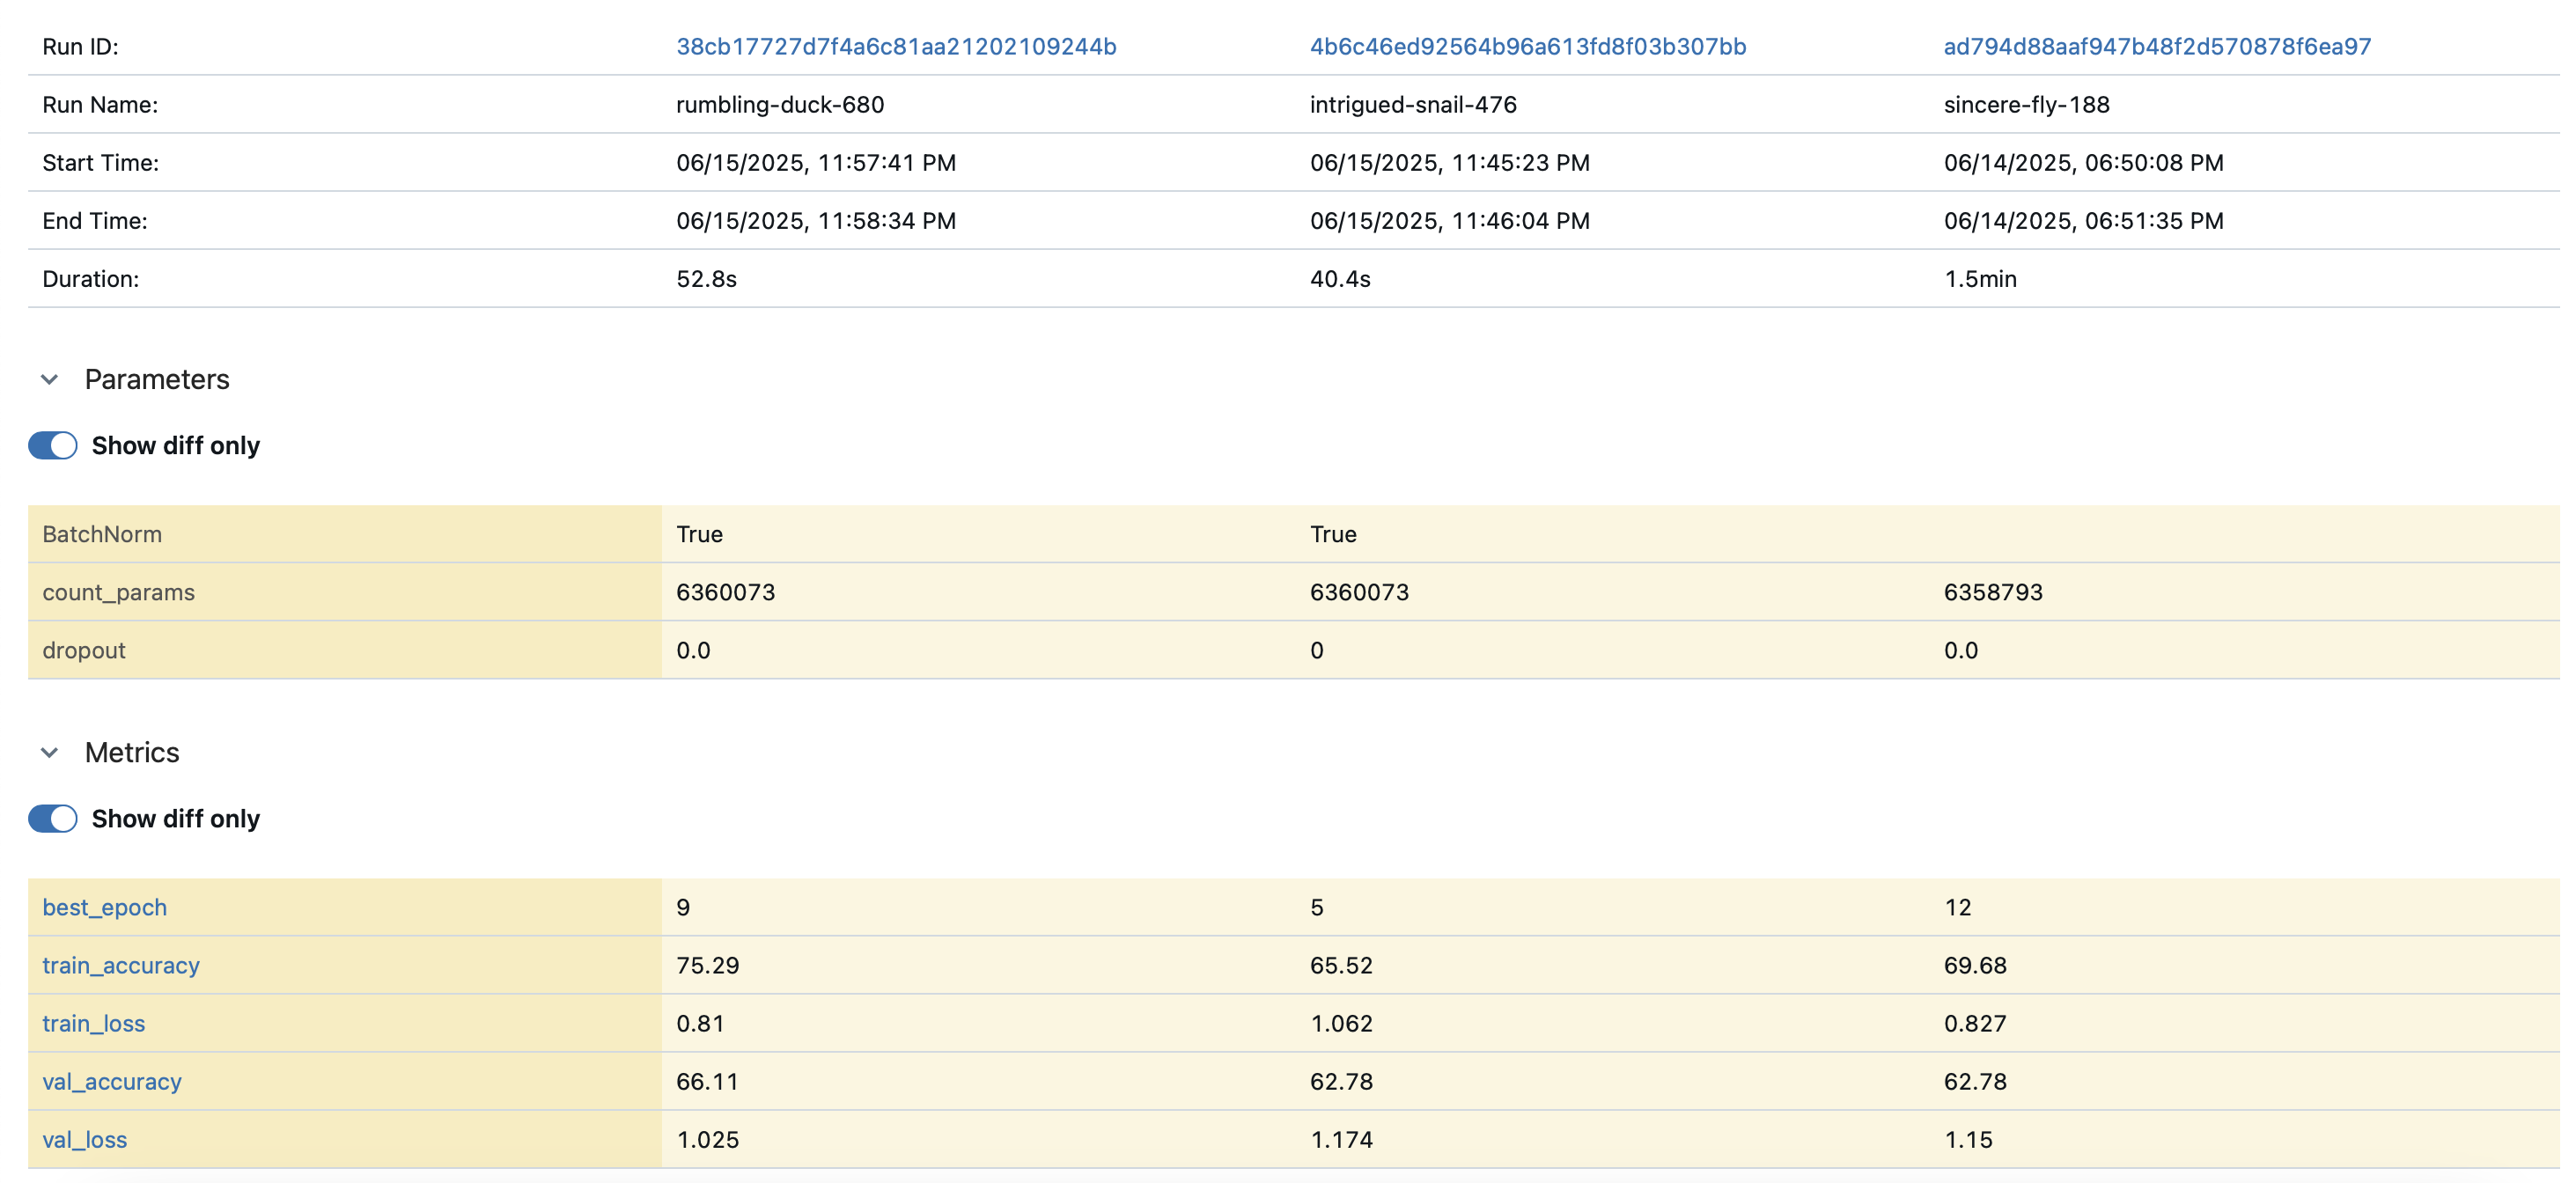

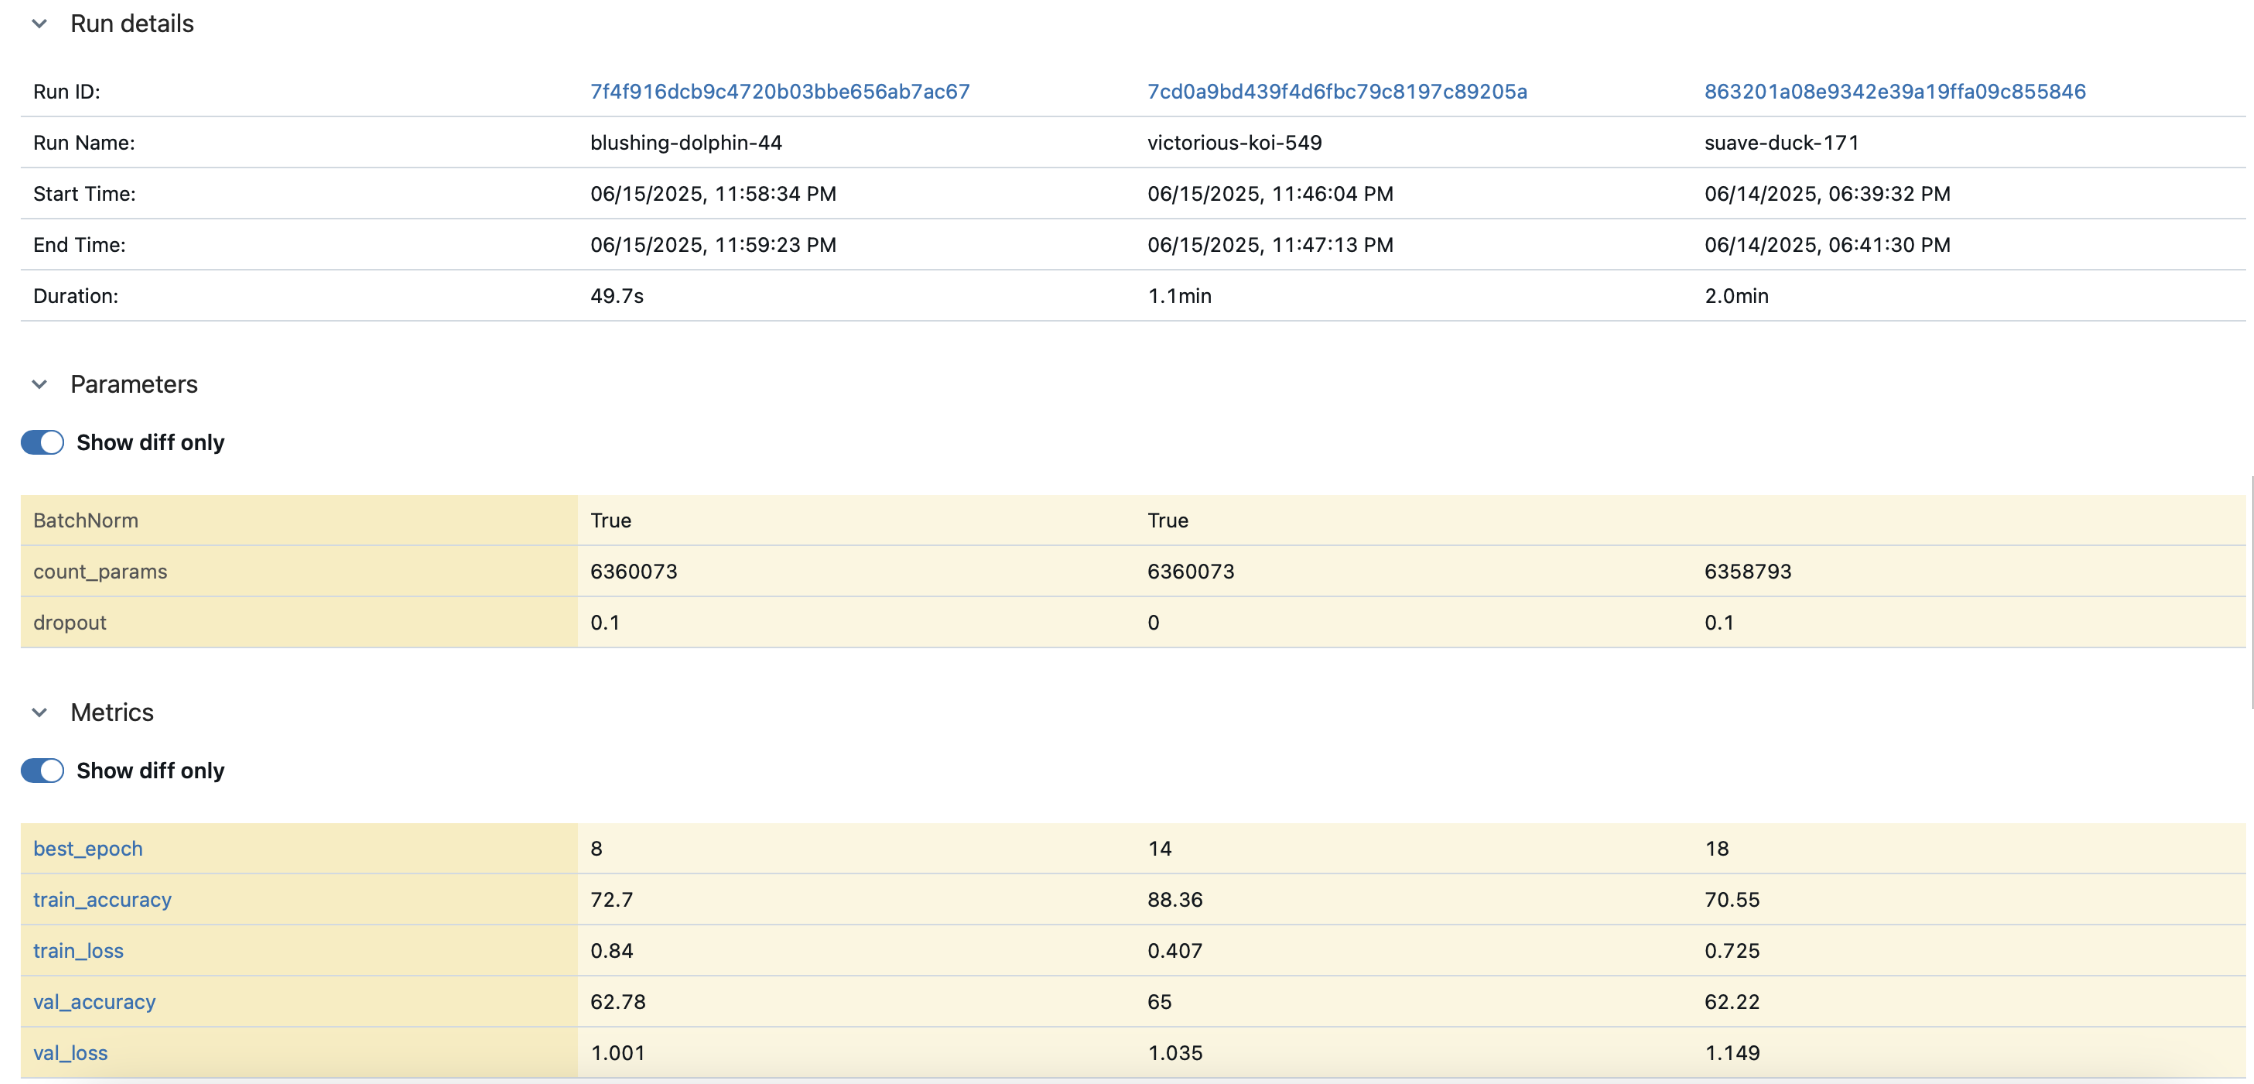

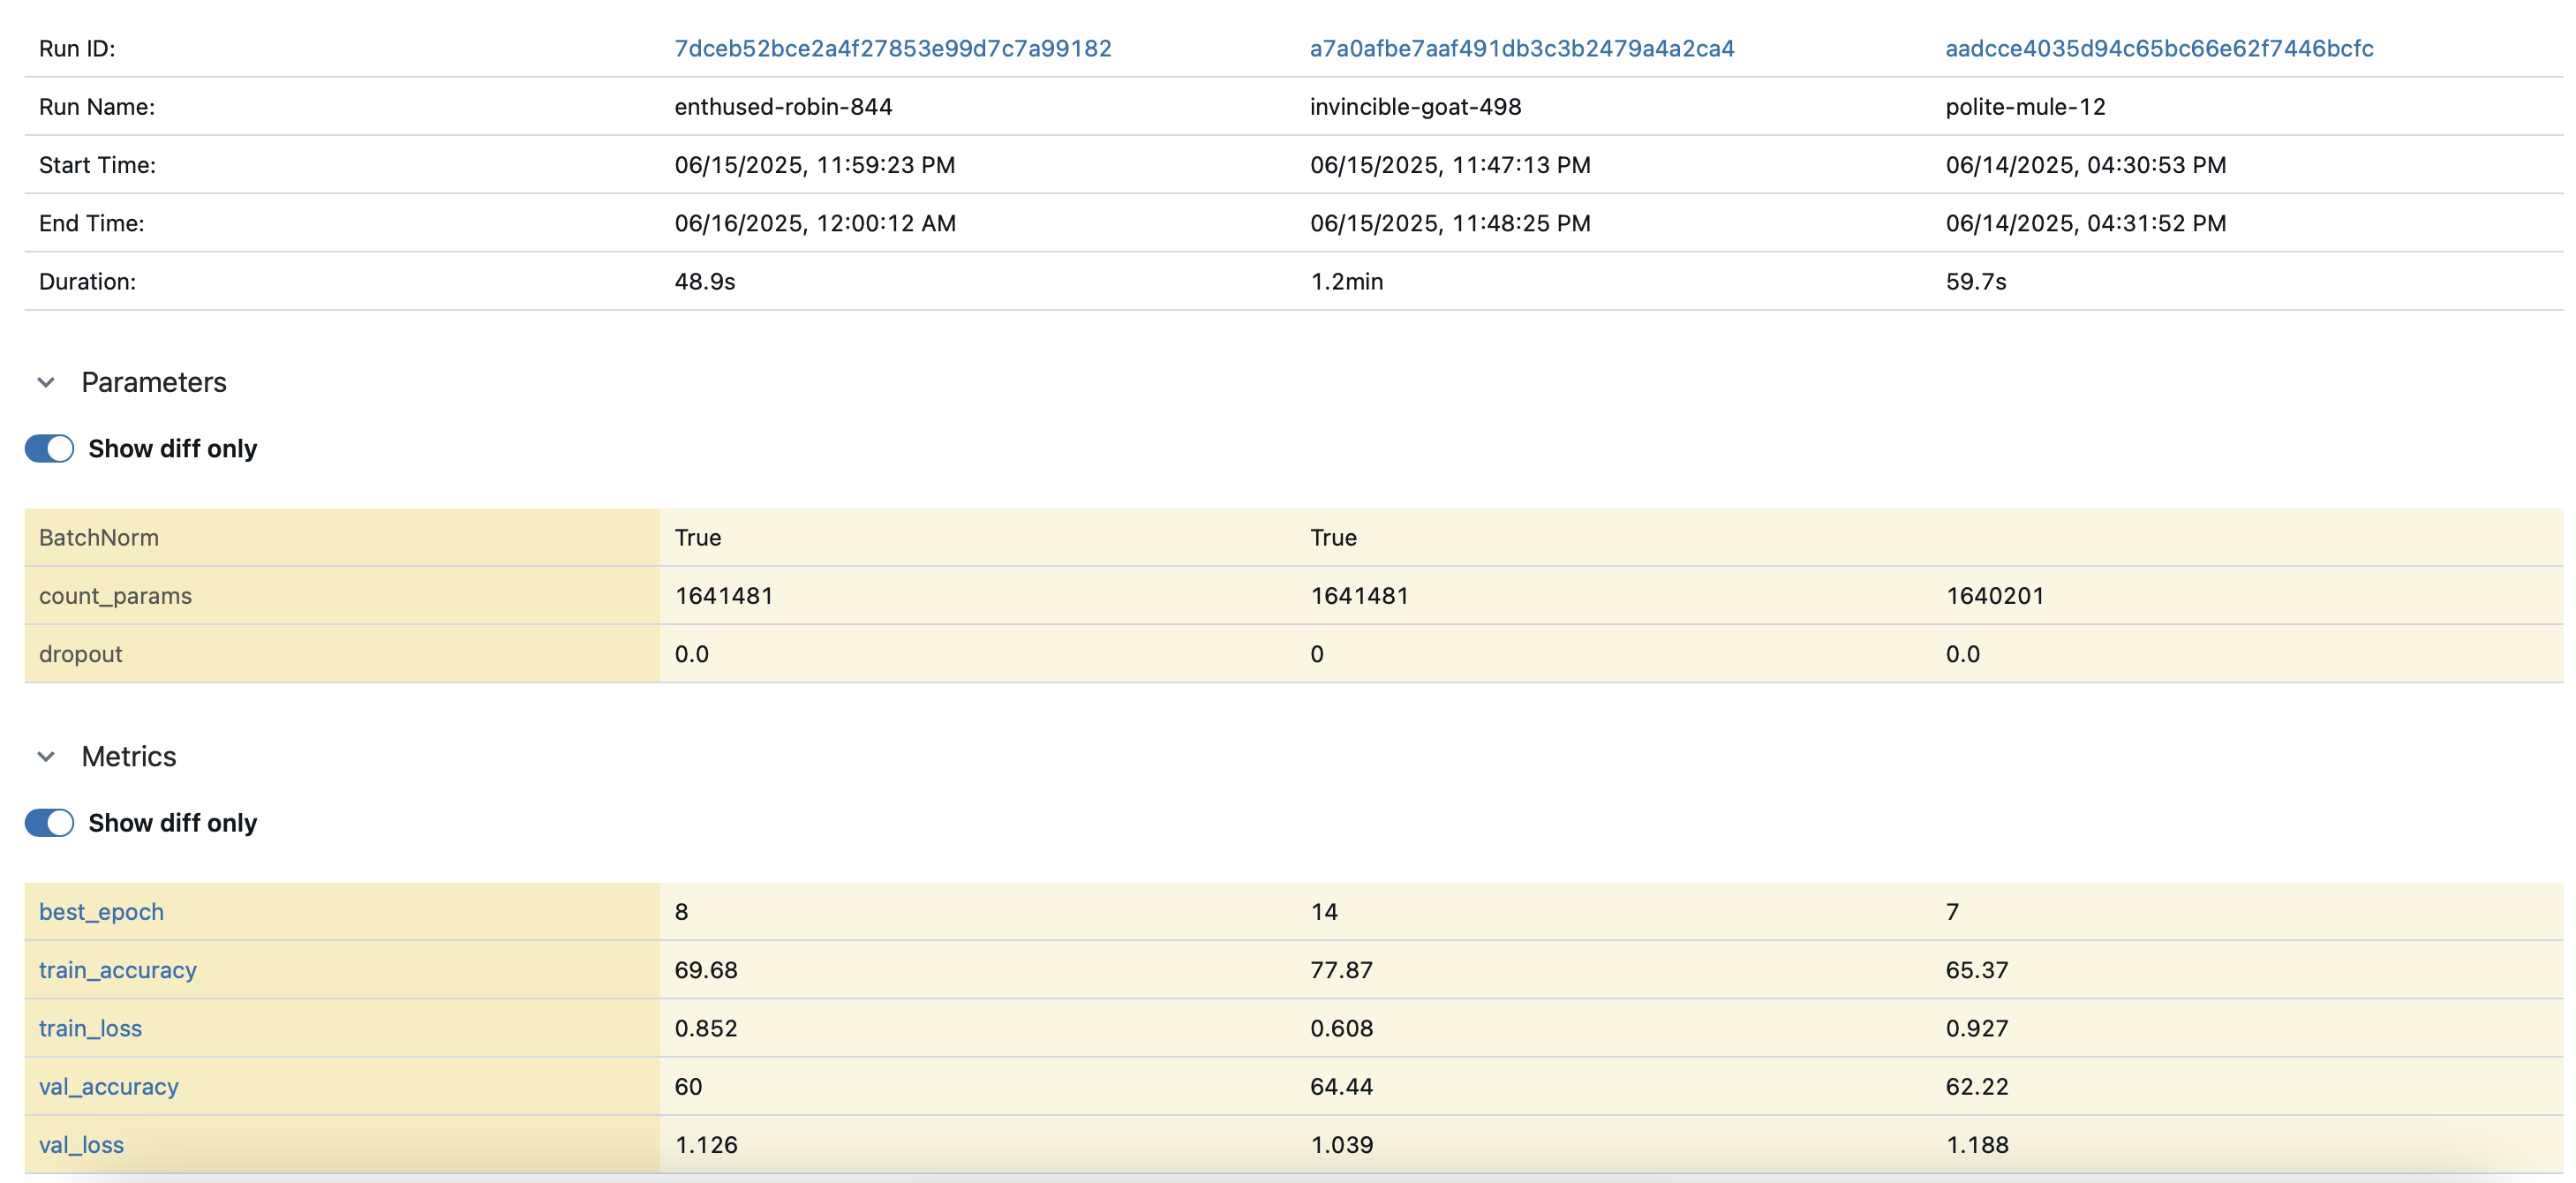

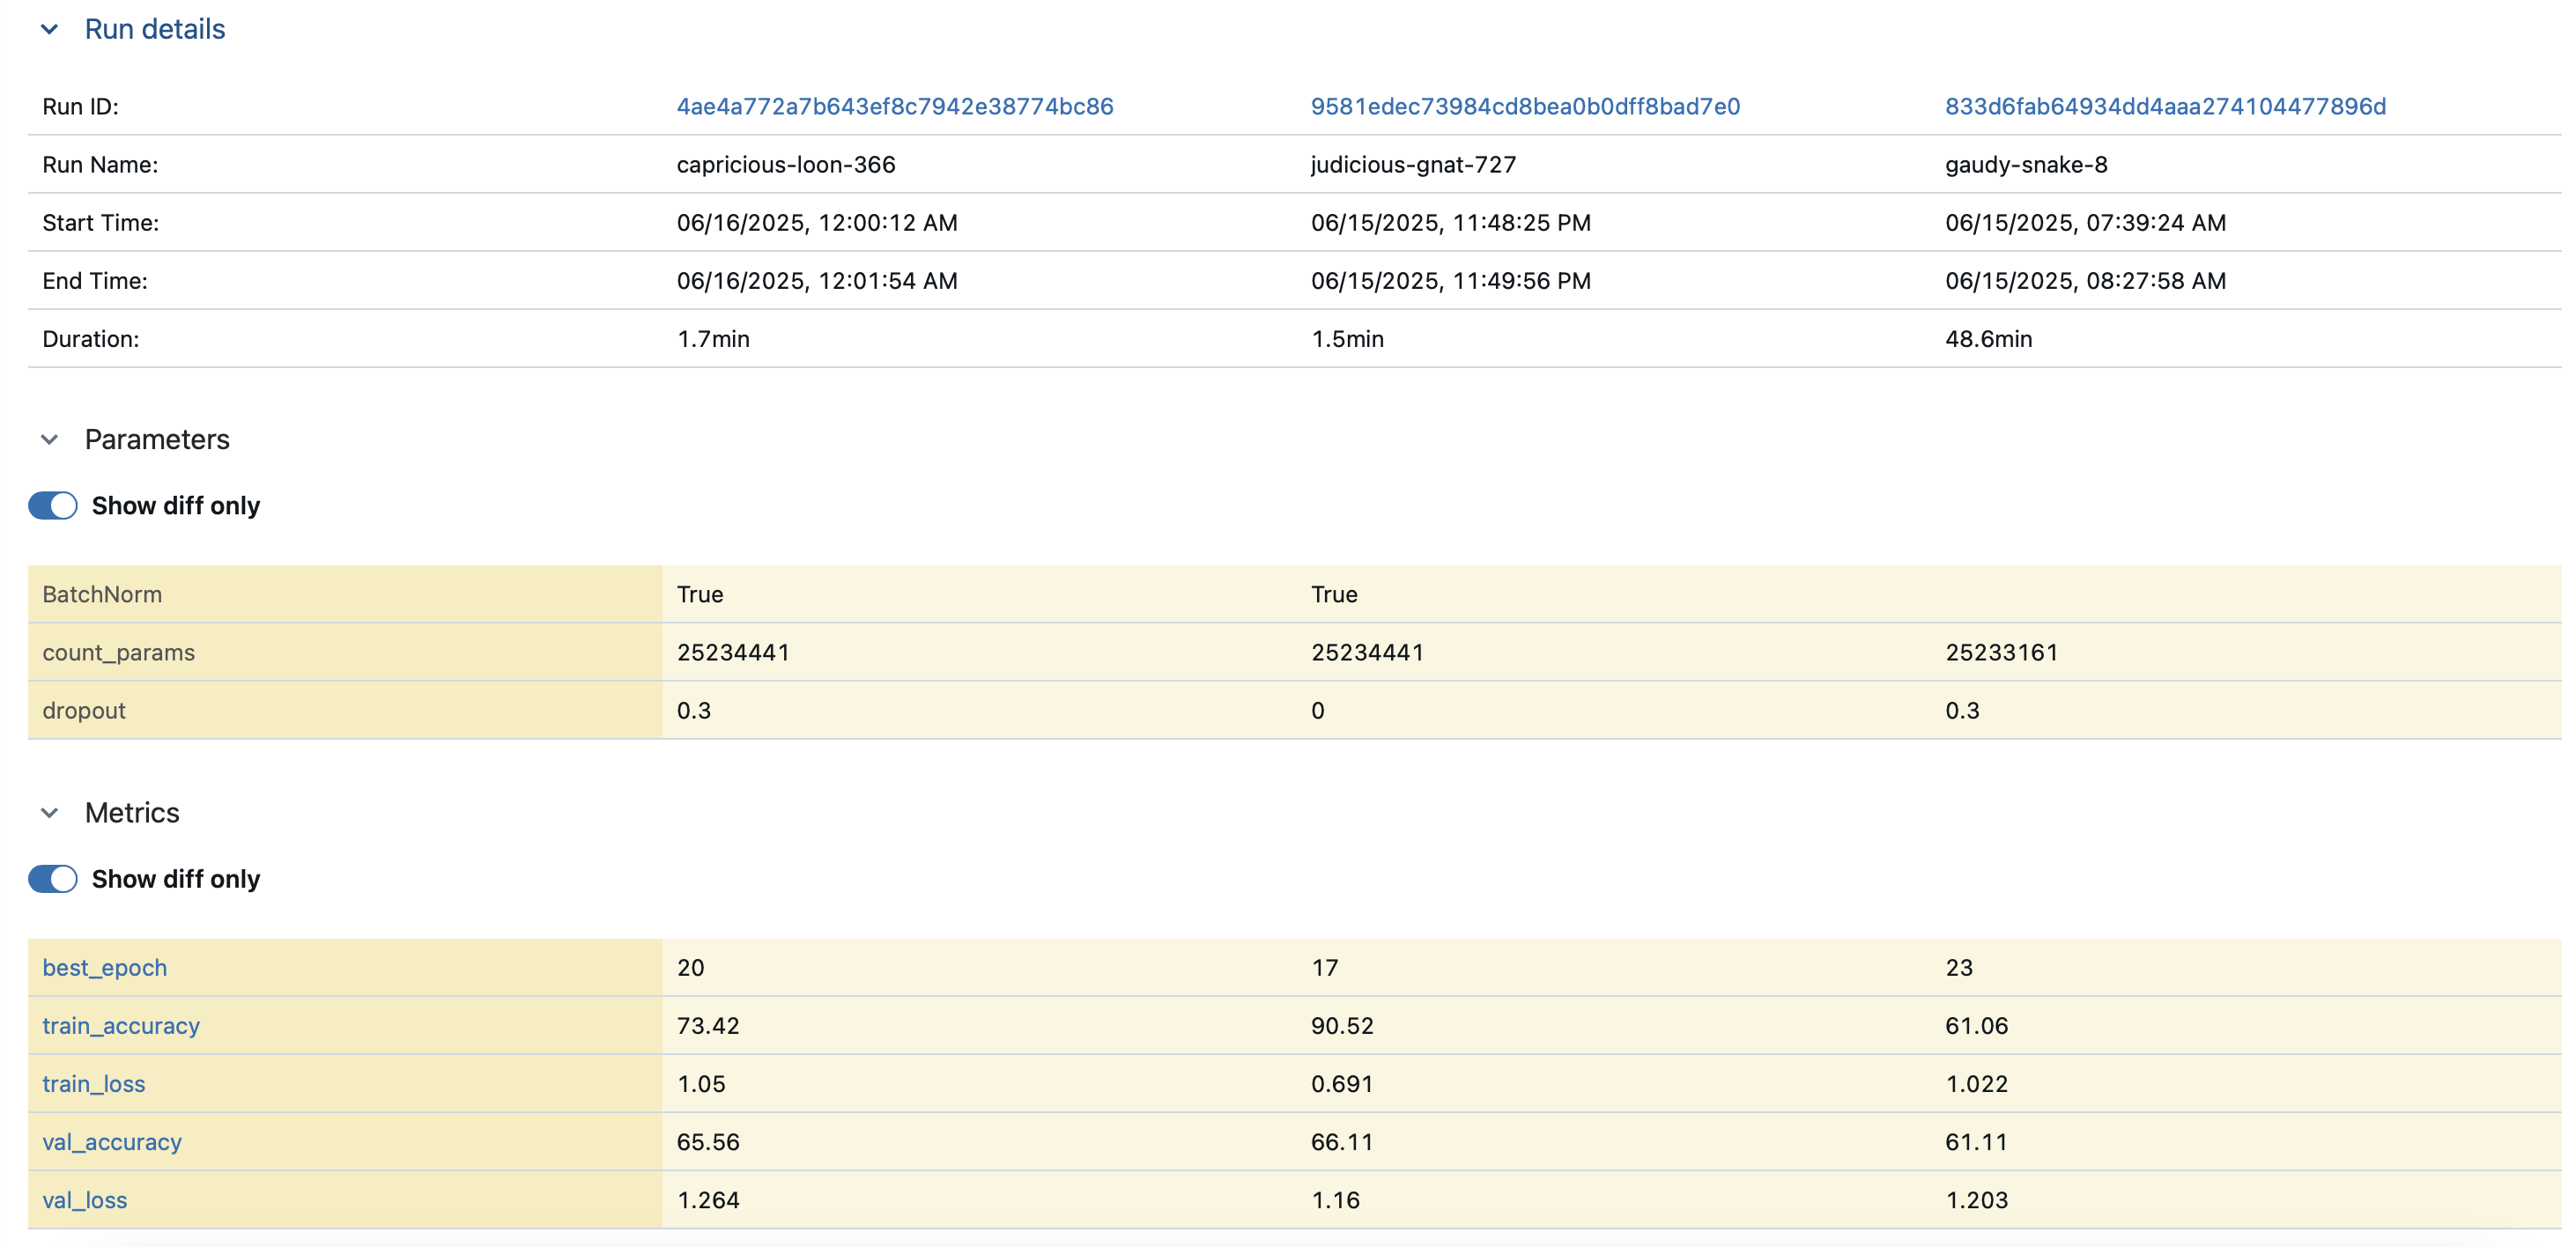

# Reestructuración de los logs en tensorboard

## Implementación BatchNormalization y Dropout

Debido a que en el modelo simple todos los runs se guardaban en el mismop log_dir, tenemos una carpeta que se fue sobreescribiendo para cada run lo cual nos impide comparar la dinámica de los modelos. Como reentrenar todos los modelos simples - sin batch norm- tarda mucho tiempo (aprox 25 mins por modelo), decidimos recuperar la información por epoch de estos 30 run ids de mlflow y convertirlos en logs de tensorboard para poder compararlos. Estos logs se guardan en una nueva carpeta (runs_compare) y luego con esto lo podemos visualizar correctamente. Además, para poder comparar los runs correspondientes a la varicación del modelo simple raiz (por cada modelo simple tenemos 2 variaciones: con BN sin dropout, con BN y dropout), los agrupamos por un `tag:compare` que varía entre 1 y 10. De esta forma logramos agrupar los runs por variación para poder observar la influencia e BN y dropout por cada modelo del cual se partió. Los nuevos directorios se agregan al `.gitignore` para evitar sobrecargar el repositorio.

In [2]:
import mlflow
from torch.utils.tensorboard import SummaryWriter
import os

In [13]:
run_ids_modeloSimple = [
    "05925b97182a43f98db25ca5fb2fbe72",
    "b21e76e4edd74d4f8688d0f9a5877f3a",
    "987d607d03d54f668c2bfb03ac14db74",
    "8c8bcb08bc0e4bc799ddbc4ad31d904a",
    "f5a8e6731e9242ee945399f24cb482e9",
    "c5cf44ada5674a97b0bfbb15062b7cff",
    "ad794d88aaf947b48f2d570878f6ea97",
    "863201a08e9342e39a19ffa09c855846",
    "aadcce4035d94c65bc66e62f7446bcfc",
    "833d6fab64934dd4aaa274104477896d"
]
run_ids_mejorados = [
    "9581edec73984cd8bea0b0dff8bad7e0",
    "4ae4a772a7b643ef8c7942e38774bc86",
    "7dceb52bce2a4f27853e99d7c7a99182",
    "7cd0a9bd439f4d6fbc79c8197c89205a",
    "a7a0afbe7aaf491db3c3b2479a4a2ca4",
    "7f4f916dcb9c4720b03bbe656ab7ac67",
    "38cb17727d7f4a6c81aa21202109244b",
    "4b6c46ed92564b96a613fd8f03b307bb",
    "d49f436fd13d4f9c9fabfbc53cf000bf",
    "8bca982a63324069b1df509c4fbd39de",
    "03be1c64359a4309a1f59ca6a0c7cc48",
    "0f3b7921cf4449d99c0bdf5ce637d39e",
    "cb452d0d48c845f290780fbb5f5c3dd8",
    "bf6a5529bc0448b9bca48da41d0d523b",
    "e9c7832a74d94e298662b1537e6a0232",
    "96fea2e161f749e49457333a0f7a54d3",
    "b2c9512f5f464074a1cbc2a47d590379",
    "adf12c74d95945eb8d0598e3bcd9834e",
    "0472143fd14f40bcbac225b150dc40b1",
    "fd7afe99f4f443ecb2cc1ea16fdba55c"
]

run_ids= run_ids_mejorados + run_ids_modeloSimple


In [14]:
# vuelvo a guardar los logs en una nueva carpeta
base_log_dir = "runs_compare"

client = mlflow.tracking.MlflowClient()

for run_id in run_ids:
    run = client.get_run(run_id)
    compare_group = run.data.tags.get("compare", "none")  # trae el tag si existe
    run_name = f"{compare_group}_{run_id[:5]}_{run.data.params.get('model', 'unknown')}_do{run.data.params.get('dropout', '0')}_bn{run.data.params.get('BatchNorm', 'False')}"

    writer = SummaryWriter(log_dir=os.path.join(base_log_dir, run_name))

    # recupero merticas x epoch de mlflow
    for metric_name in ["train/loss", "train/accuracy", "val/loss", "val/accuracy"]:
        history = client.get_metric_history(run_id, metric_name.replace("/", "_"))
        for record in history:
            writer.add_scalar(metric_name, record.value, record.step)

    writer.close()

print(f"Logs exportados a TensorBoard en: {base_log_dir}")

Logs exportados a TensorBoard en: runs_compare


Por ejemplo, para el grupo 1, si comparamos el accuracy en train y validación tenemos:

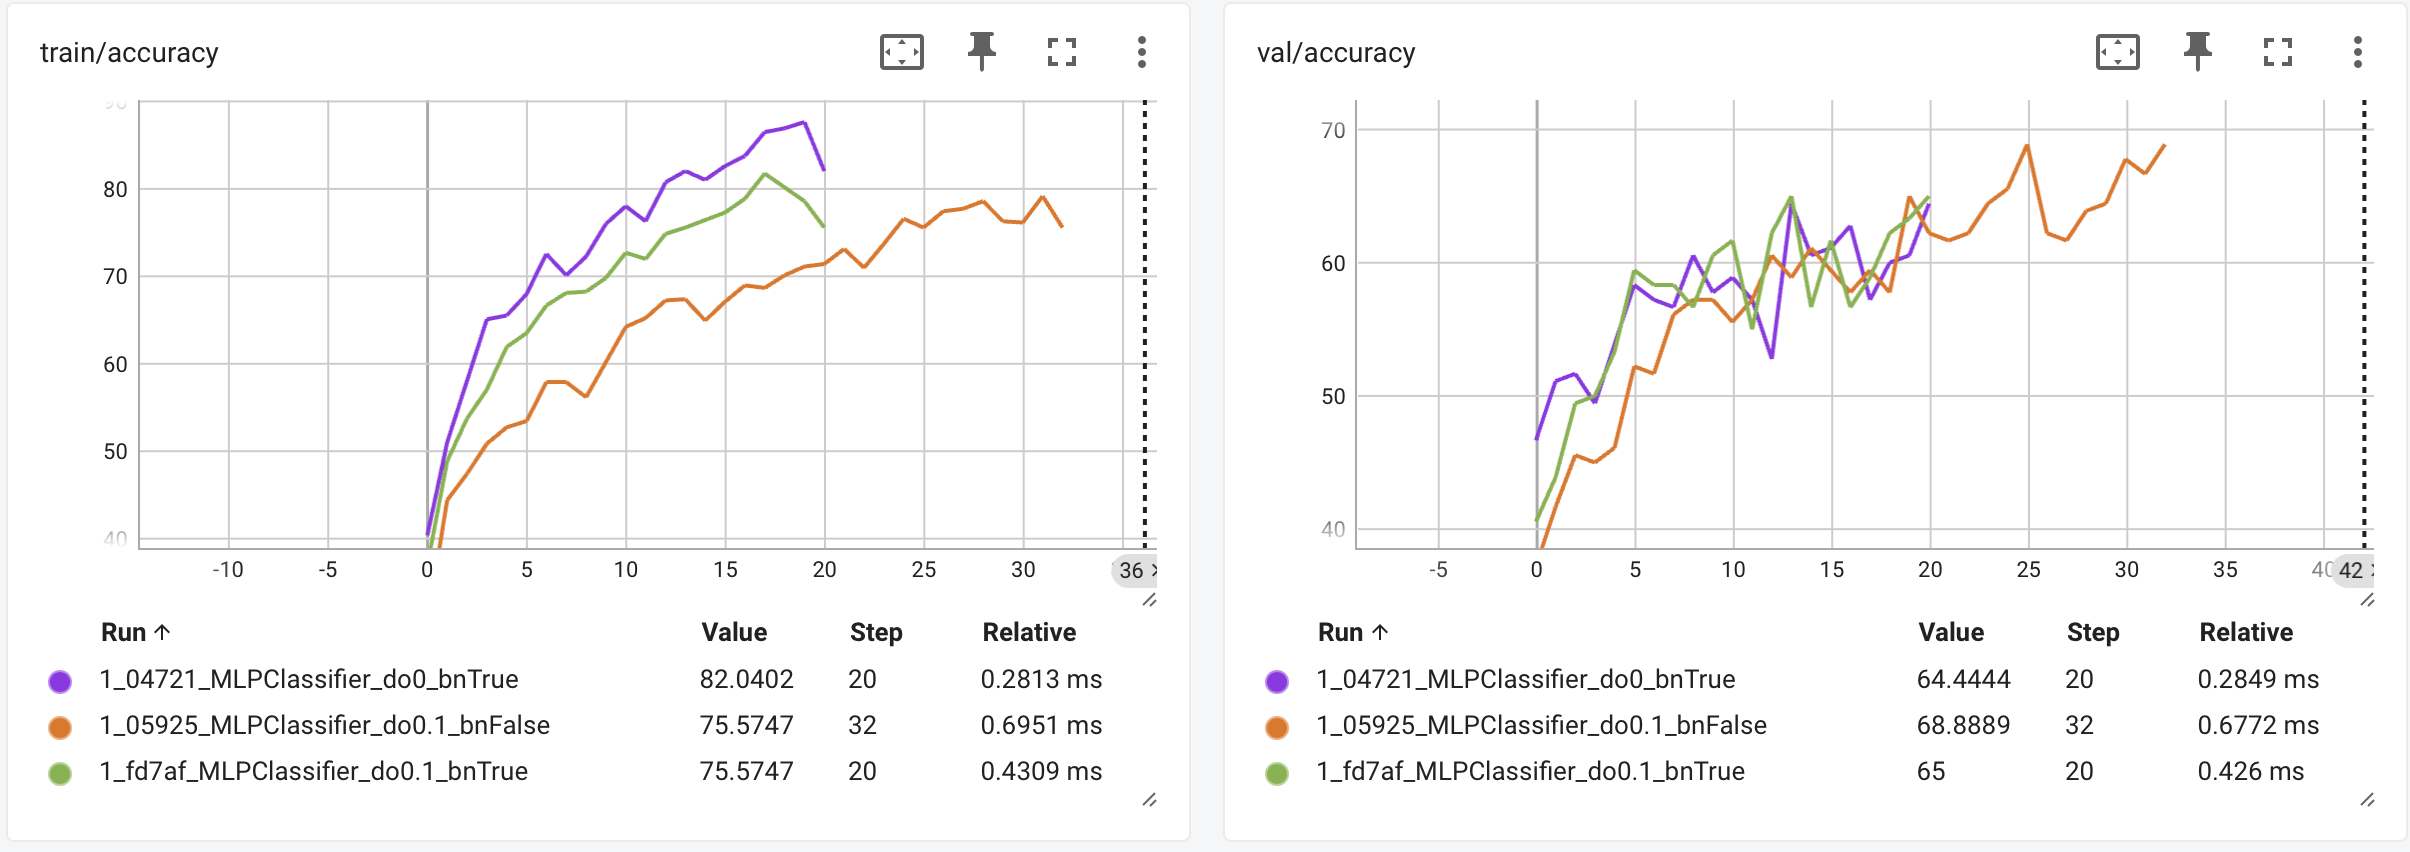
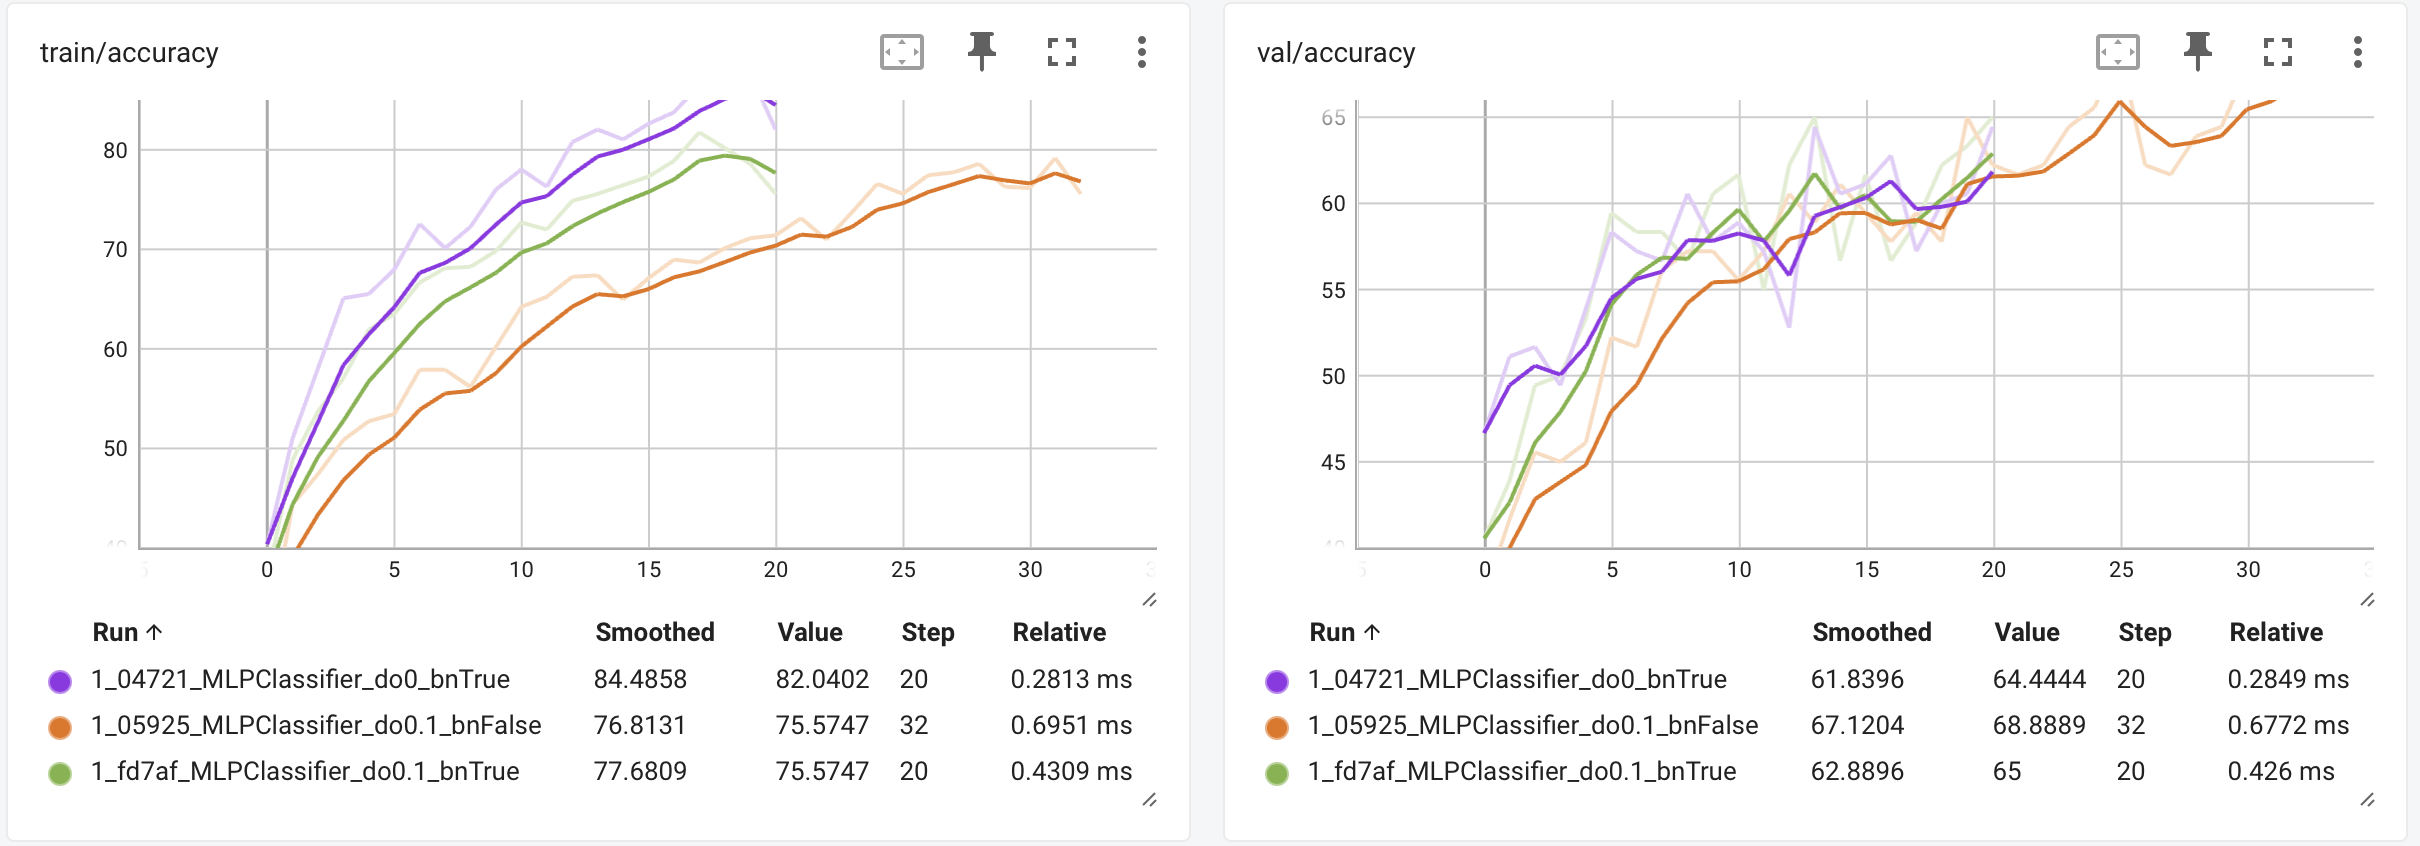

Y para la loss: 
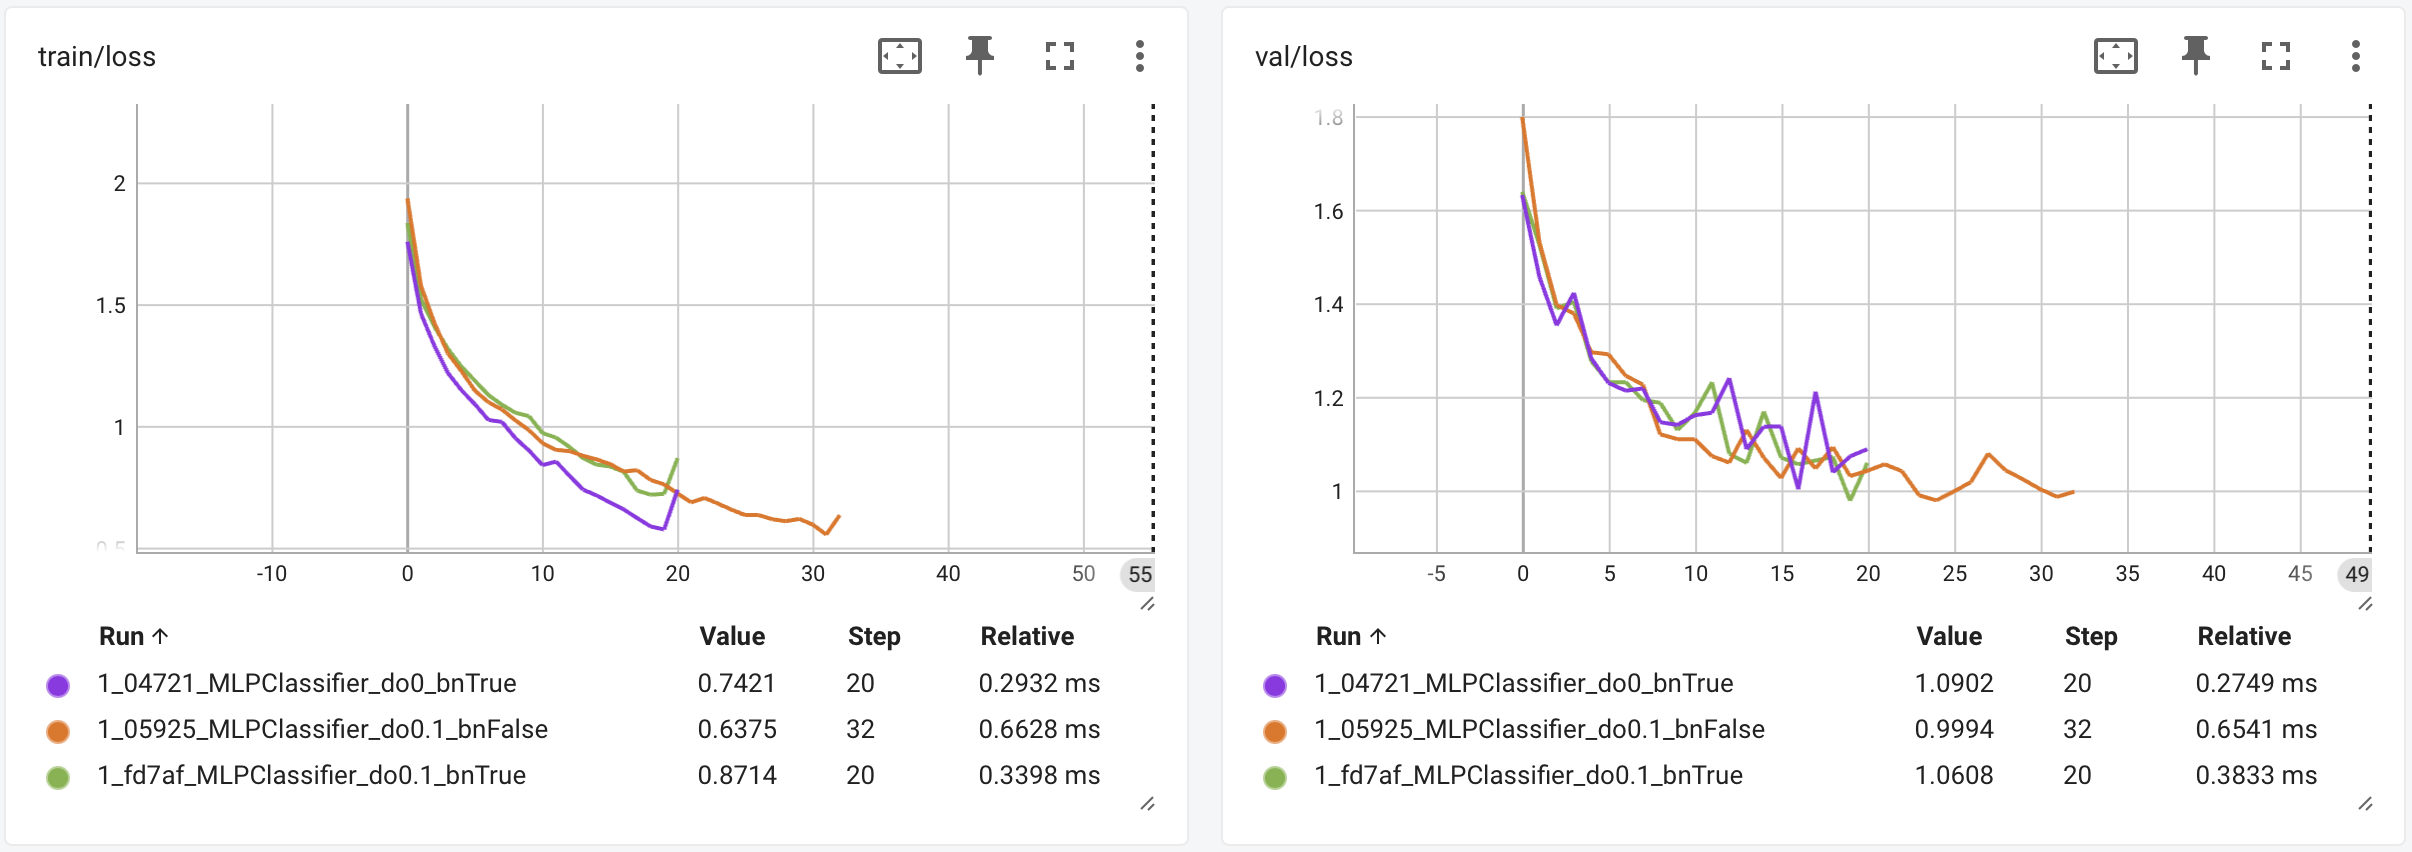
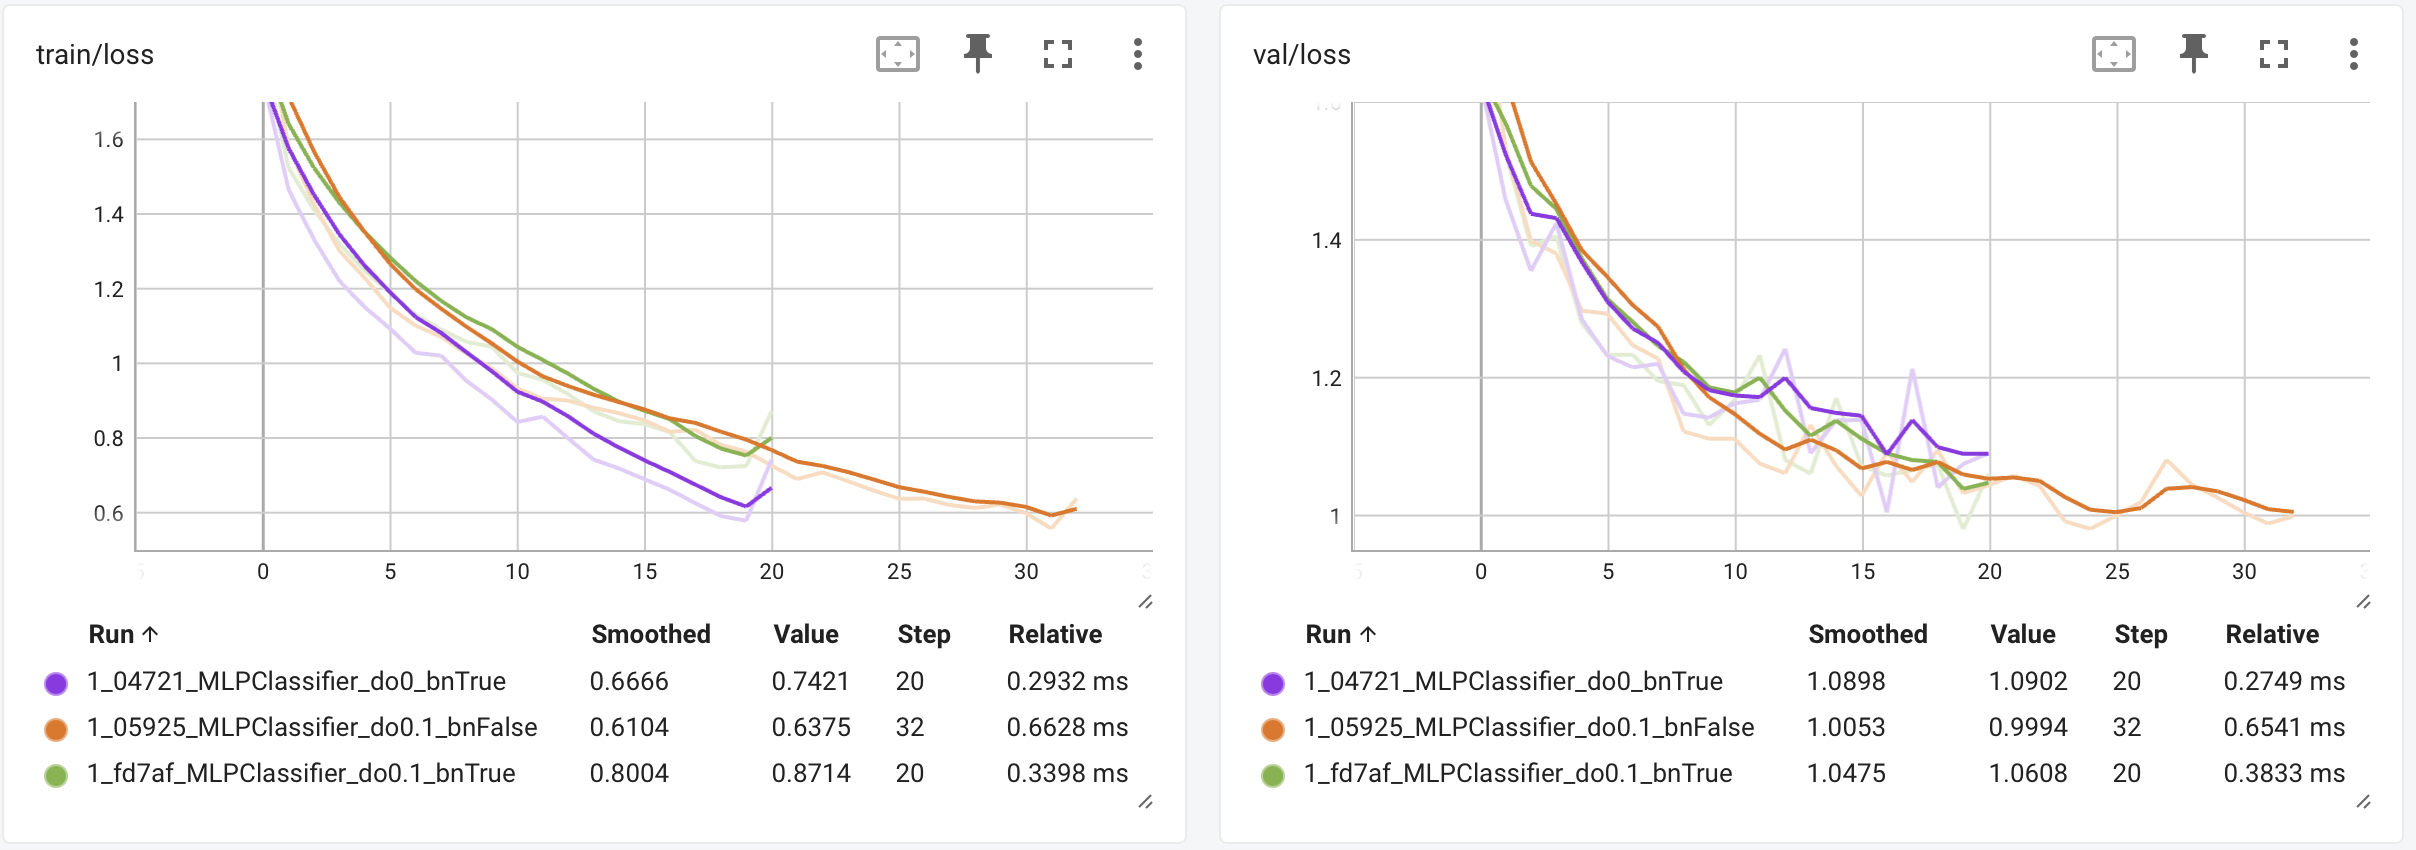

ver epoch final

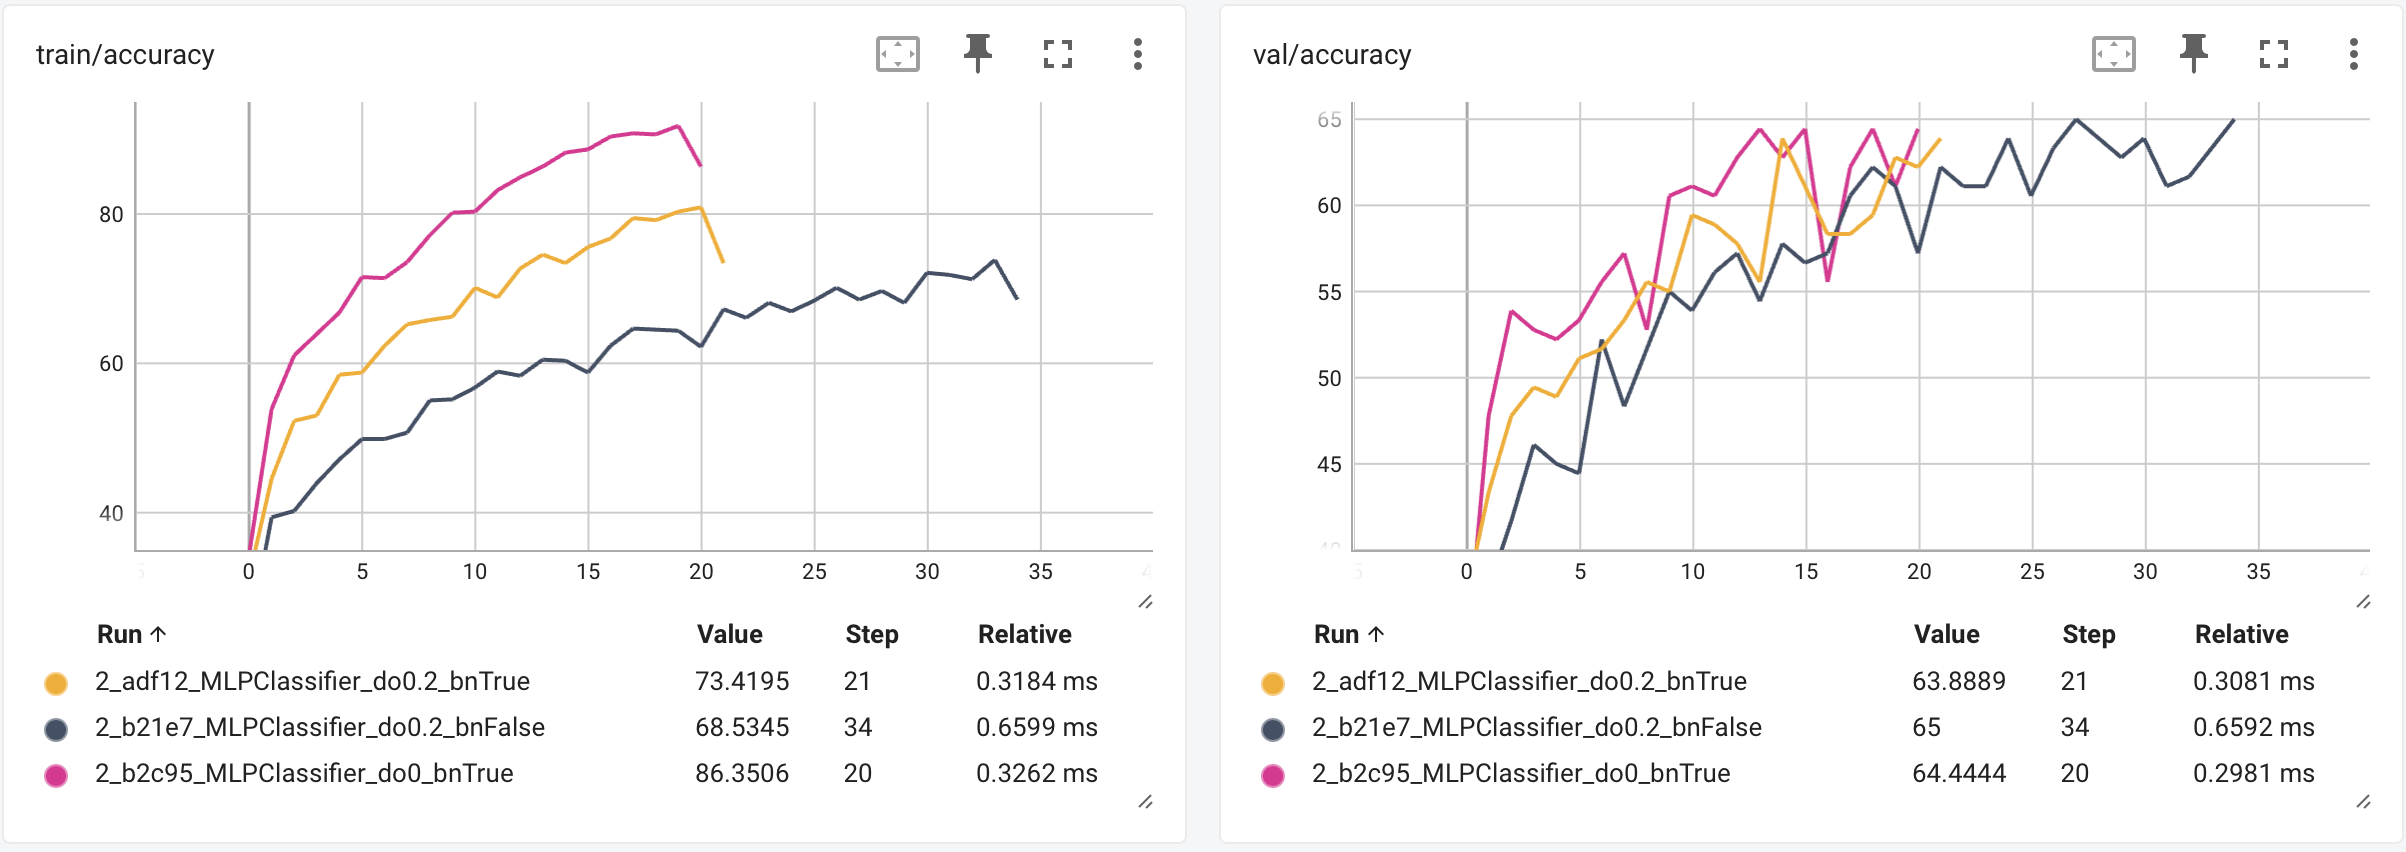

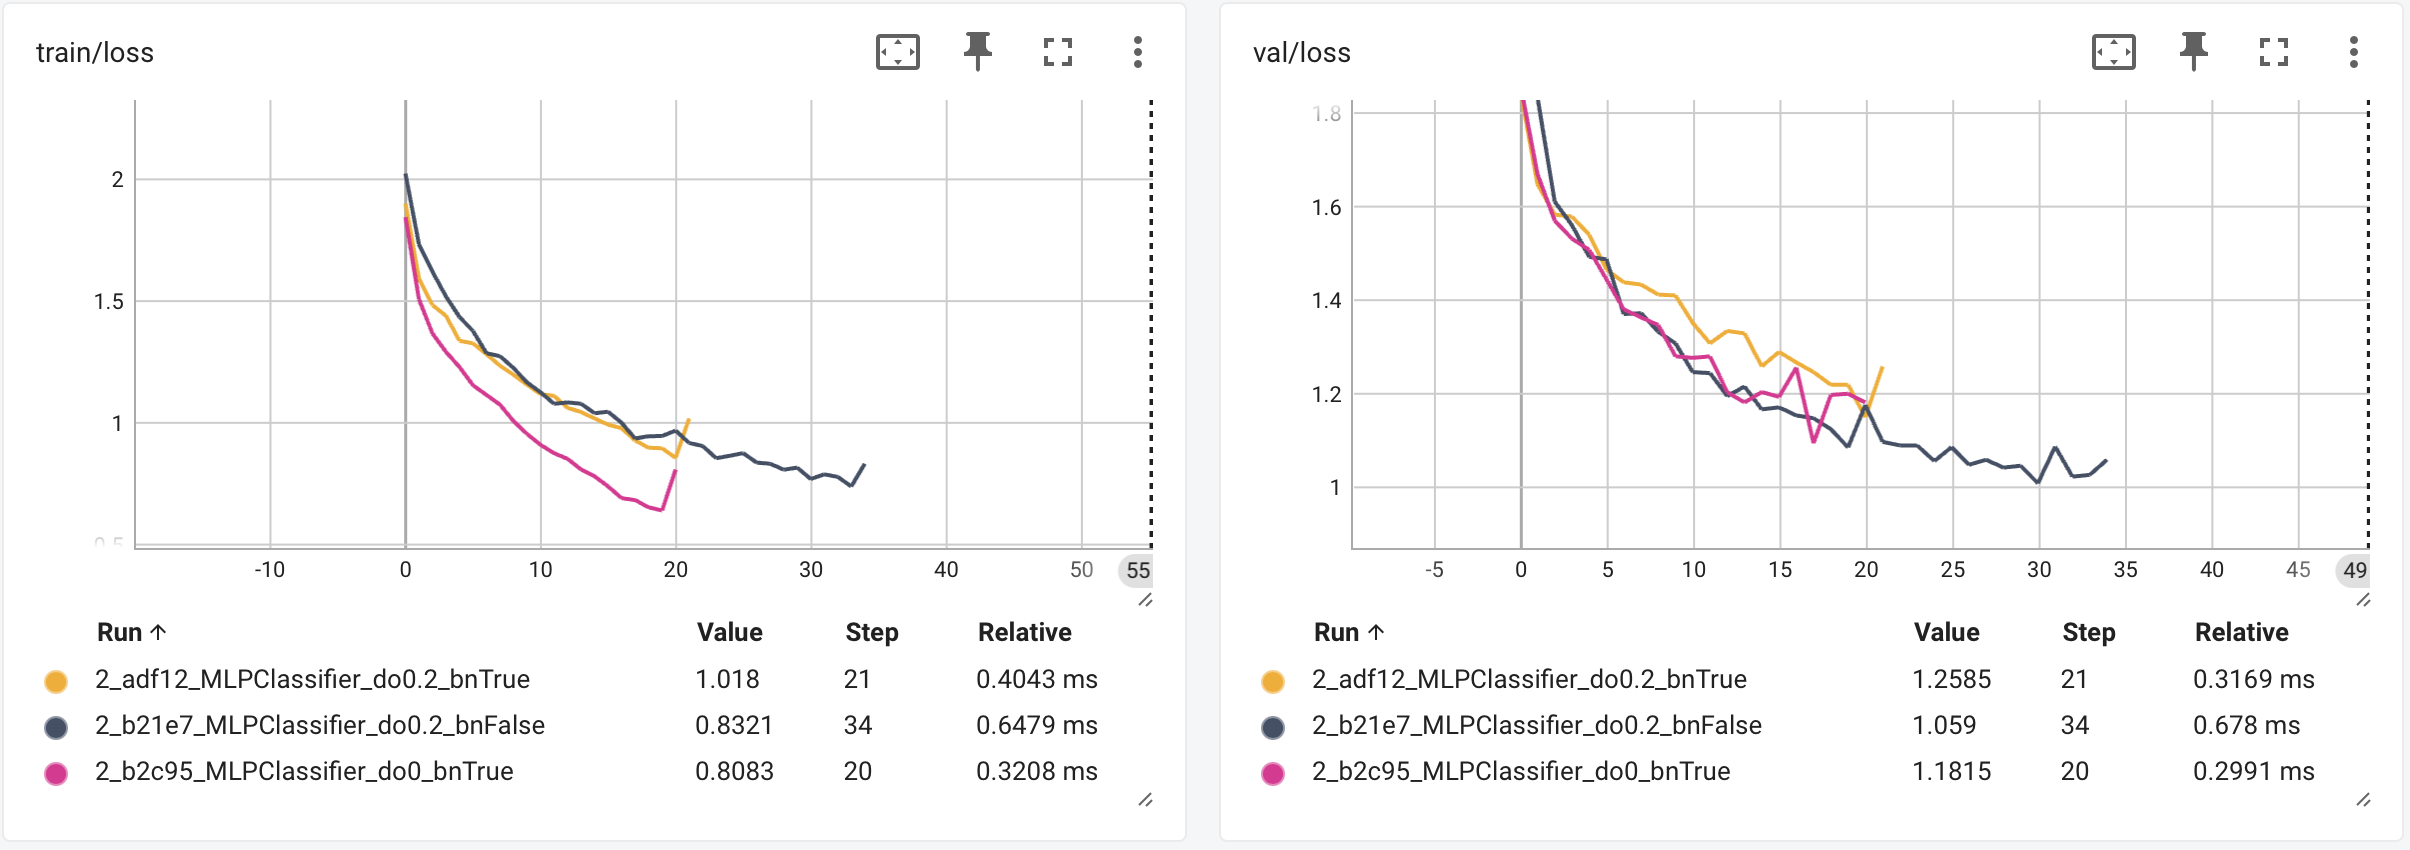

para el grupo 9:

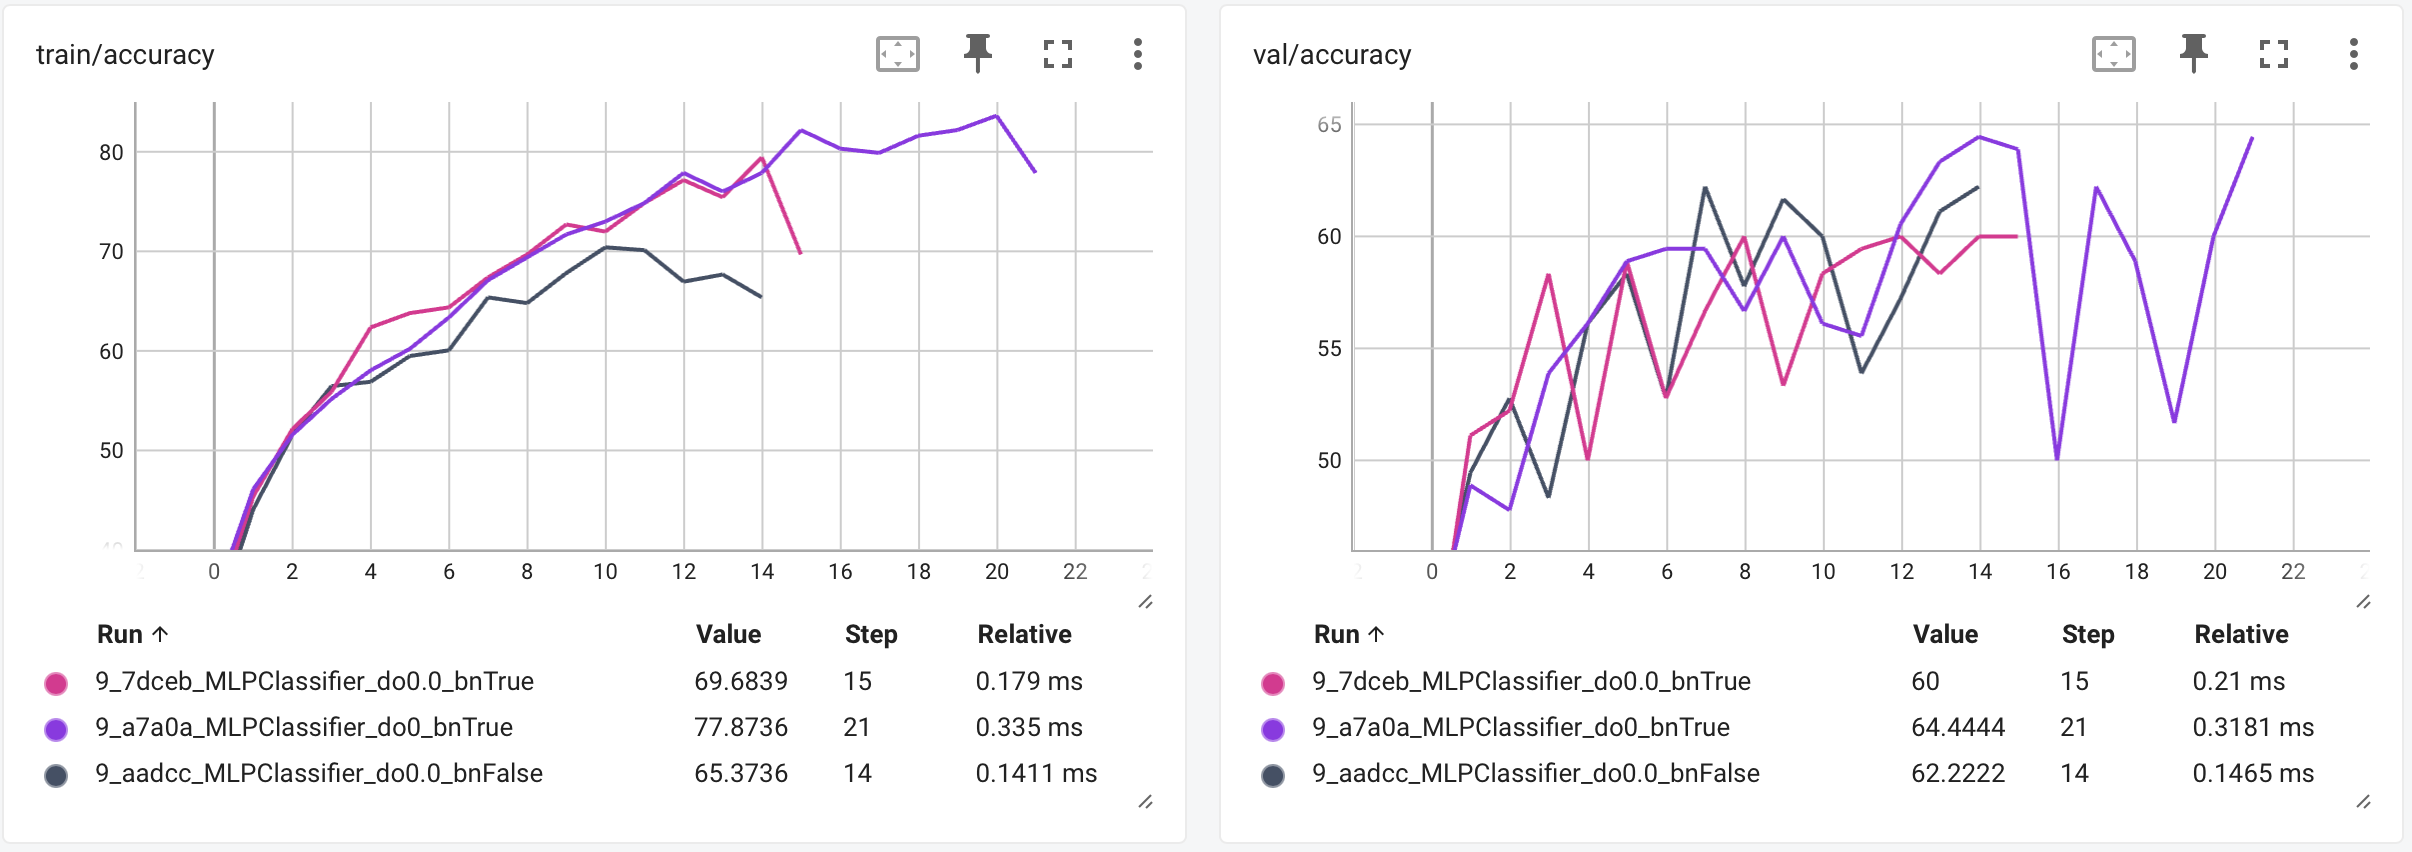

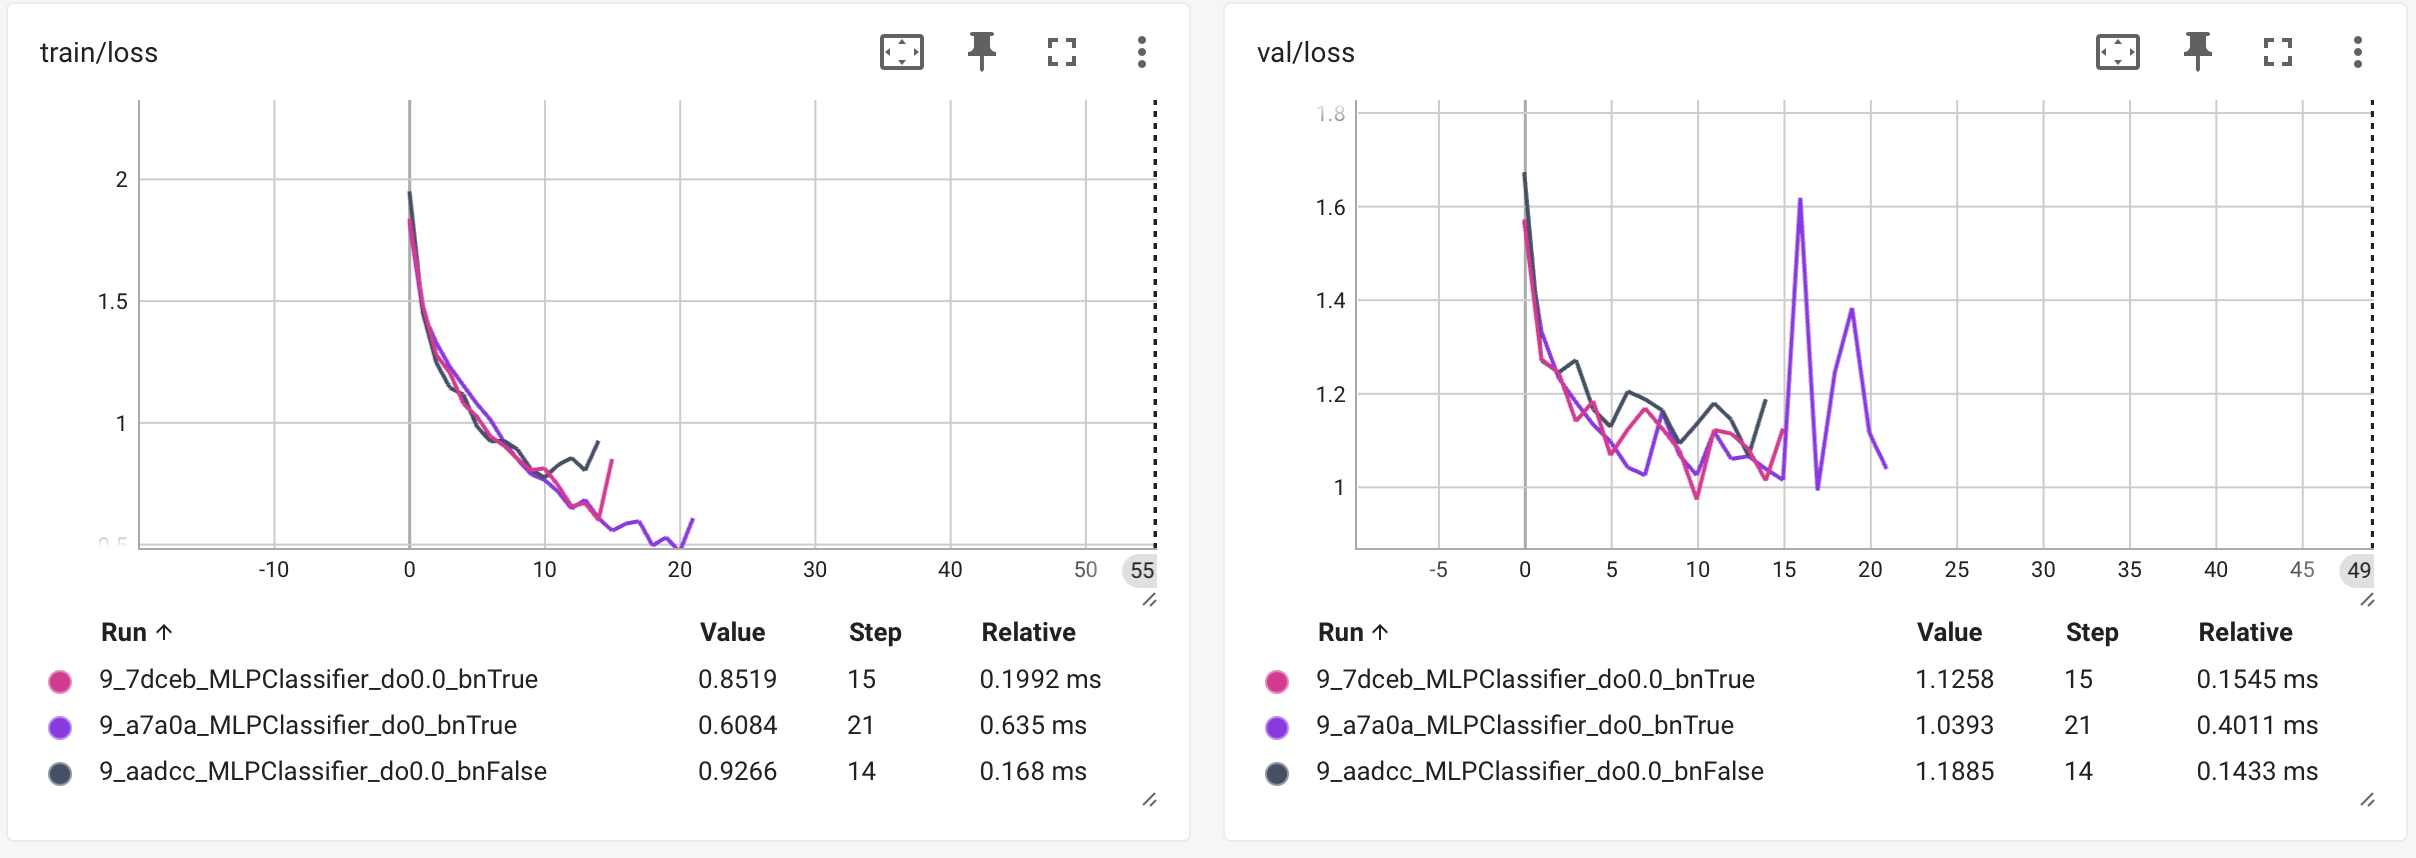

grupo 6:

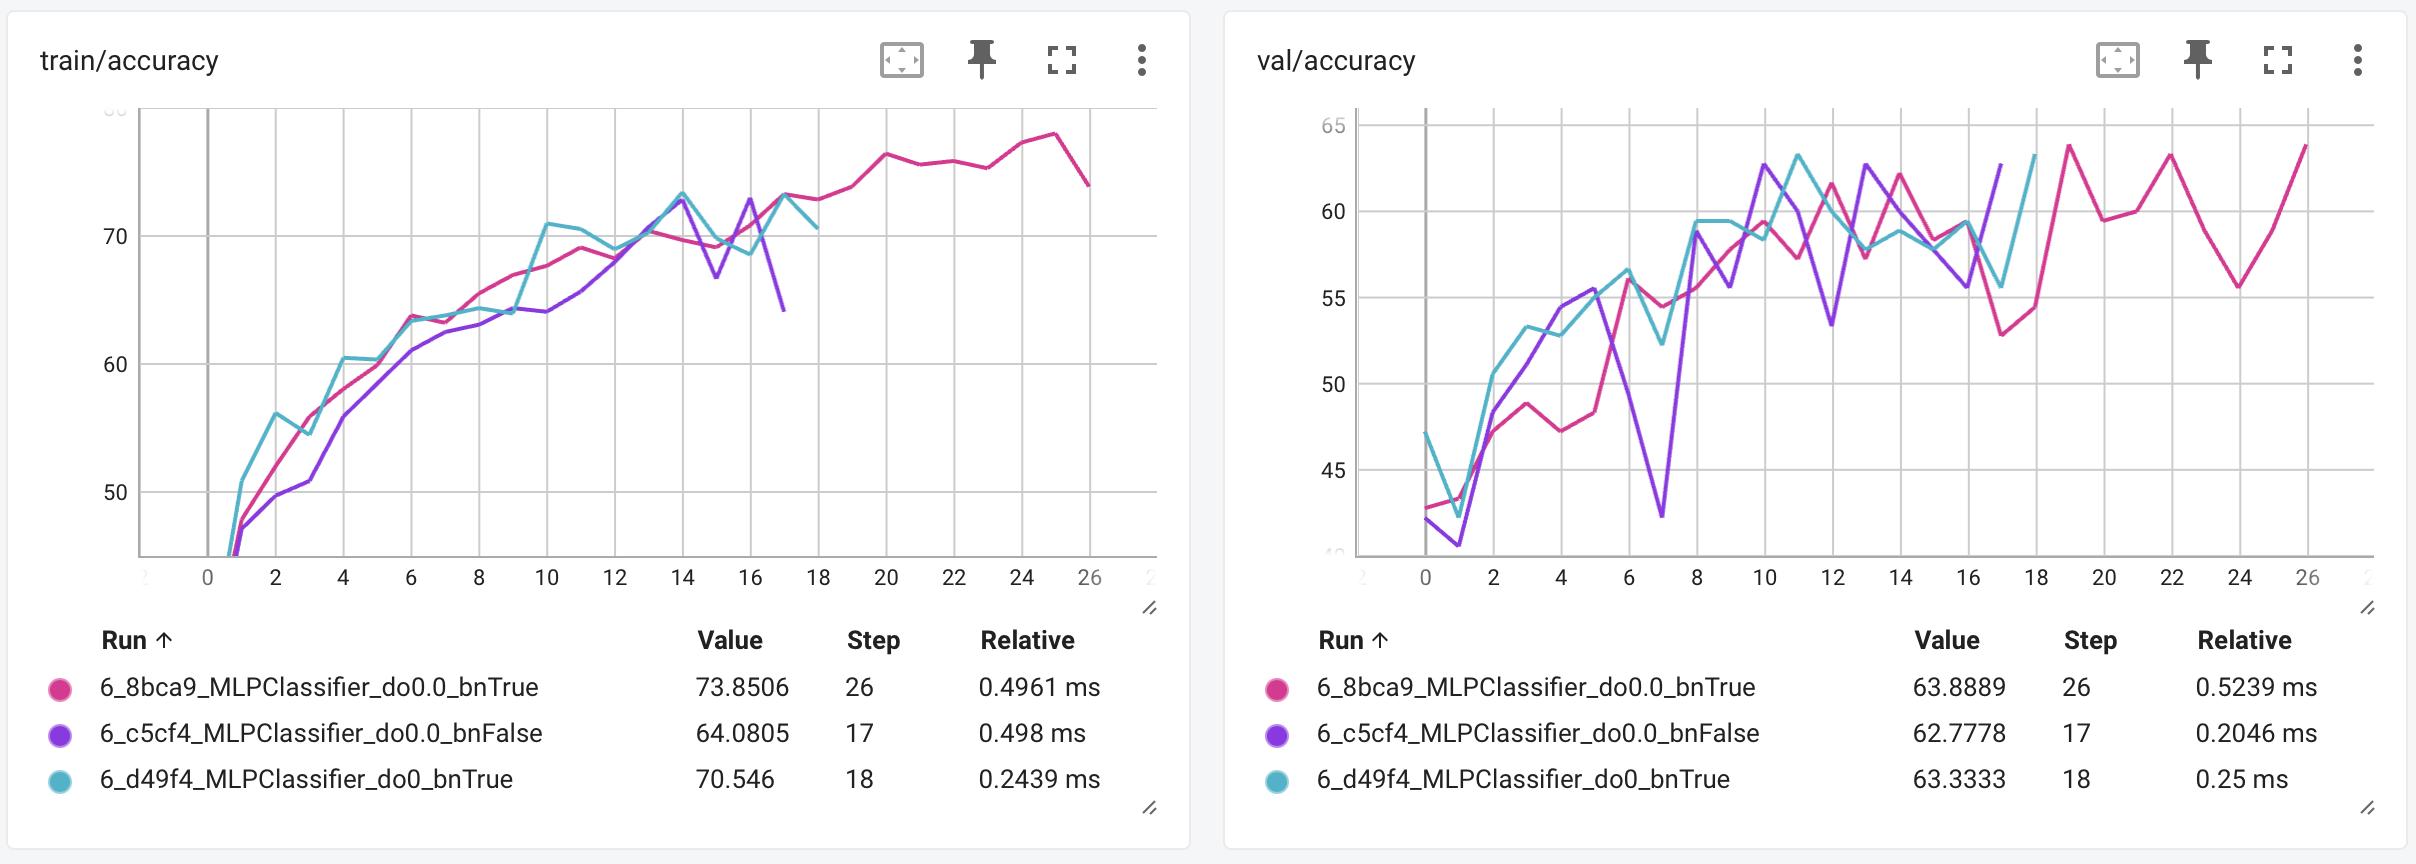

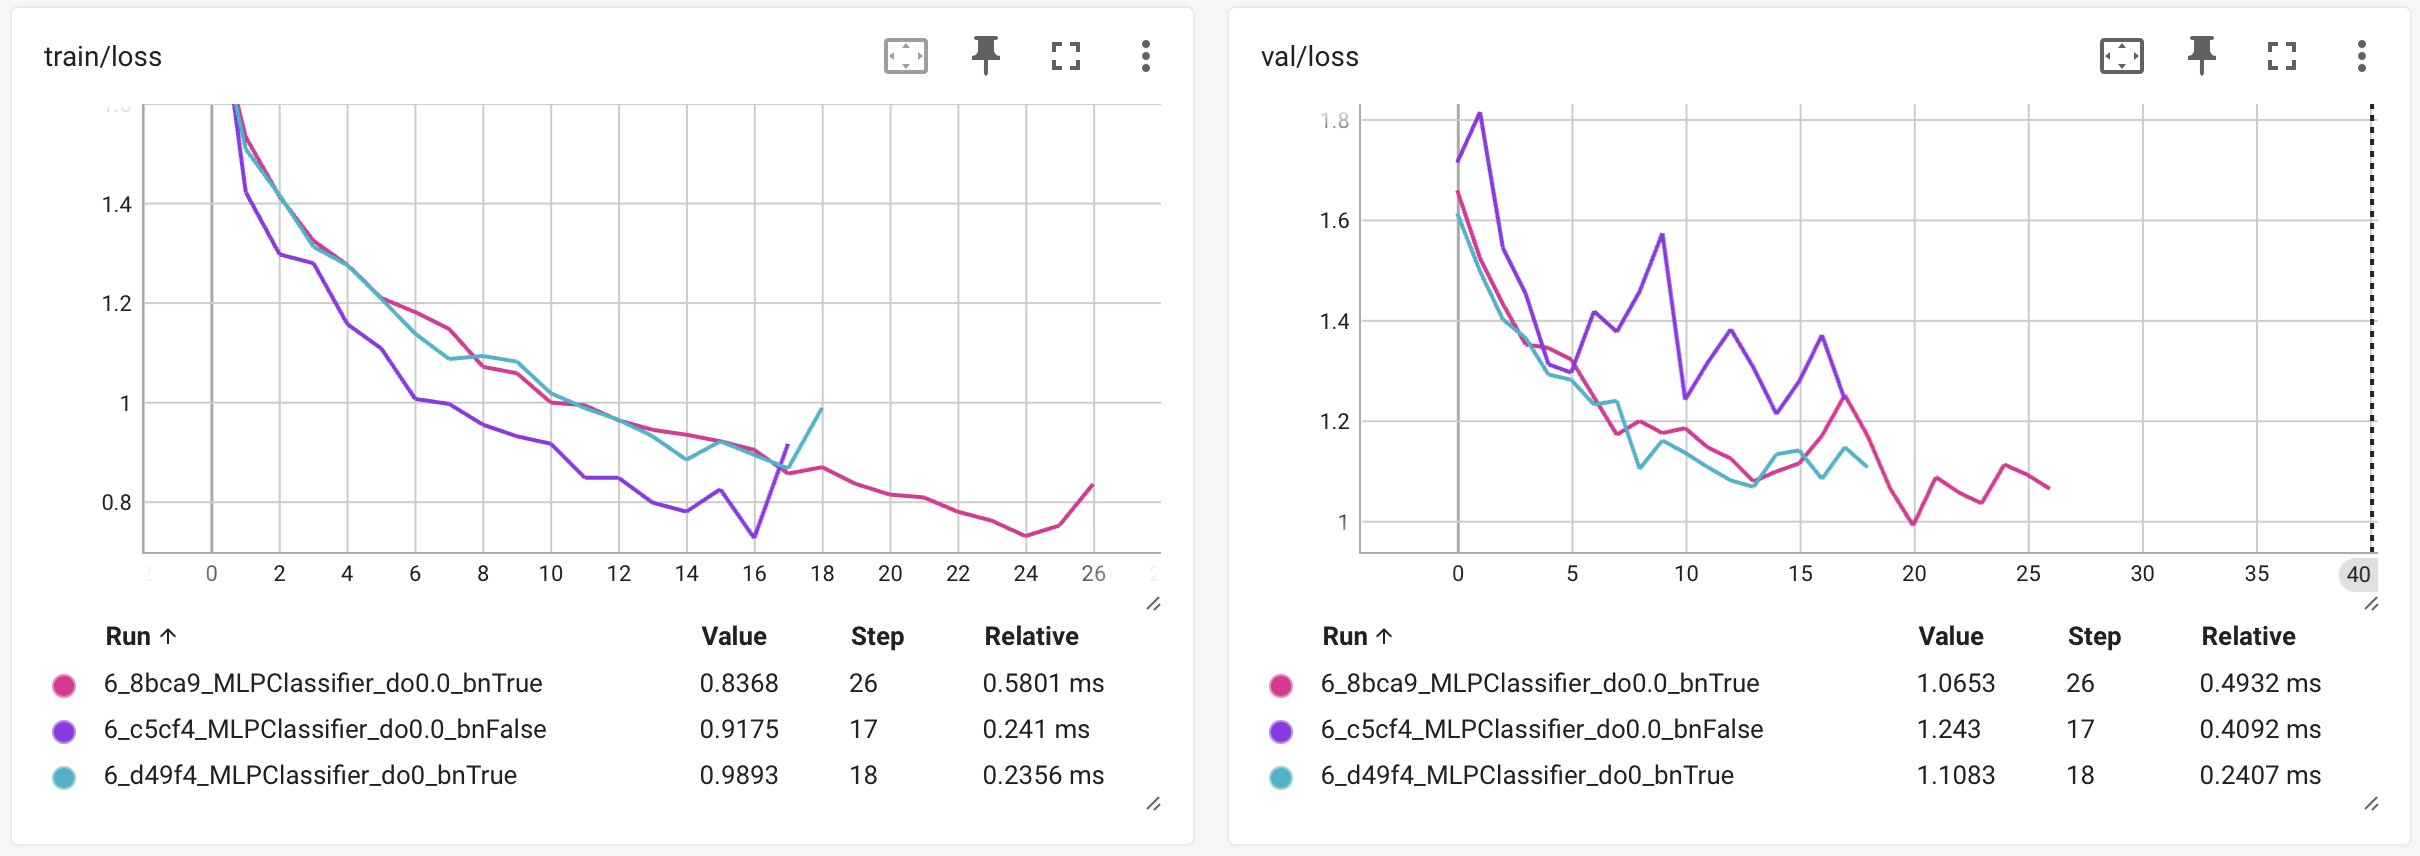

## Inicialización de pesos

Repetimos lo mismo que en el caso anterior y así recuperar los runs y logearlos correctamente en tensorbard para poder compararlos:

In [18]:
run_control=['05925b97182a43f98db25ca5fb2fbe72',
             '38cb17727d7f4a6c81aa21202109244b', 
             '9581edec73984cd8bea0b0dff8bad7e0', 
             '4ae4a772a7b643ef8c7942e38774bc86', 
             'fd7afe99f4f443ecb2cc1ea16fdba55c', 
             '7cd0a9bd439f4d6fbc79c8197c89205a', 
             'b21e76e4edd74d4f8688d0f9a5877f3a', 
             '987d607d03d54f668c2bfb03ac14db74', 
             '0f3b7921cf4449d99c0bdf5ce637d39e', 
             'a7a0afbe7aaf491db3c3b2479a4a2ca4']

In [15]:
from mlflow.tracking import MlflowClient
from torch.utils.tensorboard import SummaryWriter
import os

client = MlflowClient()
experiment_name = "Clasificador_Imagenes"  
experiment_id = client.get_experiment_by_name(experiment_name).experiment_id

# solo si tienen initializer
runs = client.search_runs(
    experiment_ids=[experiment_id],
    filter_string="params.Initializer != ''",
    max_results=30 # solo fueron 30 variaciones
)

In [16]:
base_log_dir = "runs_initializer"

for run in runs:
    run_id = run.info.run_id
    initializer = run.data.params.get("Initializer", "unknown")
    dropout = run.data.params.get("dropout", "0")
    batchnorm = run.data.params.get("BatchNorm", "False")

    run_name = f"{initializer}_{run_id[:5]}_do{dropout}_bn{batchnorm}"
    writer = SummaryWriter(log_dir=os.path.join(base_log_dir, run_name))

    for metric_name in ["train/loss", "train/accuracy", "val/loss", "val/accuracy"]:
        history = client.get_metric_history(run_id, metric_name.replace("/", "_"))
        for record in history:
            writer.add_scalar(metric_name, record.value, record.step)

    writer.close()

print(f"Logs exportados a TensorBoard en: {base_log_dir}")

Logs exportados a TensorBoard en: runs_initializer
